In [2]:
import pandas as pd
import numpy as np



from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)

import itertools
import pprint
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Can machine learning techniques solve the epidemic of fake news?
## Approaches to News classification and recommendations for building a production sized News Classifier

### Motivation

Since the 2016 election "fake news" has spread through our public discourse and public trust in the media has dramatically declined. I've been an avid follower of the news since the 2016 campaign and I've been pretty sensitive to how the publications I subscribe to inform my opinion. I wanted to see how well machine learning algorithms can classify article



## Problem Question
If there is a standard set of classes for news that reflect an article's trustwortiness, 

1) How can you make a news classification model with a labeled set of data? 
2) What features would be most important for this model?
3) What would be the architecture and needs for a production sized news classifier?


## Datasets

I will be working with two datasets one from kaggle and from George McIntire opendatascience blog post as they contain different fields lend themselves better to separate analysis.

1) Kaggle- 12,999 entries: "contains text and metadata from 244 websites and represents 12,999 posts in total from the past 30 days. The data was pulled using the webhose.io API [...] Each website was labeled according to the BS Detector as documented here: https://github.com/selfagency/bs-detector. Data sources that were missing a label were simply assigned a label of "bs". There are (ostensibly) no genuine, reliable, or trustworthy news sources represented in this dataset (so far), so don't trust anything you read."

#### Kaggle Data Dictionary- Features to note
- **published**: date/time published (10-26-16 to 11-25-16)
- **title**: title of article
- **text**: : text of article
- **language**: data from webhose.io 
- **site_url**: site URL from BS detector 
- **replies_count**: number of replies 
- **participants_count**: number of participants 
- **likes**: number of Facebook likes
- **comments**: number of Facebook comments
- **shares**: number of Facebook shares
- **type**: type of website (label from BS detector) "bs", "bias", "conspiracy", "hate", "satire", "state", "junksci", and "fake" **No "real" labeled articles**


2) McIntire dateset- 6335 entries labeled either "REAL" or "FAKE". "REAL" articles scraped from Allsides.com, a website dedicated to hosting news and opinion articles from across the political spectrum. Articles on the website are categorized by topic and by political leaning (left, center, and right). "REAL" articles were from 2015 to 2016 and came from media the organizations the New York Times, WSJ, Bloomberg, NPR, and the Guardian. "FAKE" articles are a random subset of "bs" articles from the kaggle dataset. The data has a 50% split in the class labels

#### McIntire Dictionary
- **title**: title of article
- **text**: : text of article
- **label**: "REAL" or "FAKE"

## Data Cleaning/Organizing

In [3]:
McIntire= pd.read_csv('fake_or_real_news.csv', index_col=0)
kaggle= pd.read_csv('fake.csv')

In [4]:
McIntire.shape, kaggle.shape

((6335, 3), (12999, 20))

In [5]:
kaggle["label"]=kaggle["type"]
kaggle=kaggle.drop('type', axis=1)

#change name of site_url to source
kaggle["source"]=kaggle["site_url"]
kaggle=kaggle.drop("site_url", axis=1)

le1 = LabelEncoder()
kaggle['numerical_label']=le1.fit_transform(kaggle['label'])
kaggle = kaggle.reset_index(drop=True)

In [6]:
le2 = LabelEncoder()
McIntire['binary_label']=le2.fit_transform(McIntire['label'])
McIntire = McIntire.reset_index(drop=True)

In [7]:
def cleaner(text):
    '''Cleans text for token analysis'''
    try:
        text = re.sub('[.,\/#!$%\^&\*;:{}\+=<>_`~()]', ' ', text)
        text = re.sub('[^a-z0-9 ]','', text.lower())
        text = re.sub('\s+',' ',text)
    except: 
        pass
    return text

In [8]:
def get_date(date):
    '''Formats date from published column'''
    date=date[:10]
    date=datetime.strptime(date, '%Y-%m-%d')
    
    return date

In [9]:
def get_time(time):
    '''Formats time from published column'''
    time=time[11:16]
    time=datetime.strptime(time, '%H:%M')
    
    return time

In [10]:
#CLEAN TEXT for both
McIntire["text"]=McIntire["text"].apply(cleaner)
McIntire["text"] = McIntire["text"].fillna('')

kaggle["text"]=kaggle["text"].apply(cleaner)
kaggle["text"] = kaggle["text"].fillna('')

In [11]:
#GET DATE; GET TIME for kaggle
kaggle["date"] = kaggle['published'].apply(get_date)
kaggle["date"] = pd.to_datetime(kaggle["date"])

kaggle["time"] = kaggle['published'].apply(get_time)
kaggle["time"] = pd.to_datetime(kaggle["time"])


kaggle["month"] = kaggle["date"].dt.month
kaggle["day"] = kaggle["date"].dt.day
kaggle["year"] = kaggle["date"].dt.year

In [12]:
#Look at unique labels
kaggle['label'].value_counts().unique

<bound method Series.unique of bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: label, dtype: int64>

In [13]:
#add fake to bs since there arent that many fake articles for kaggle
kaggle.loc[kaggle['label'] == "fake", 'label'] = "bs"

In [14]:
#feature engineering: make social reach score from social reach cols for kaggle
social_reach_cols=["replies_count", 'participants_count', 'likes', 'comments','shares']
feature_engineer_df=kaggle[social_reach_cols]

#scale each column from 0-1 then add there values to get "social_reach_score"
scaler=MinMaxScaler()
for col in feature_engineer_df.columns:
    x_scaled = scaler.fit_transform(feature_engineer_df[social_reach_cols])
    feature_engineer_df[col]=x_scaled


kaggle["social_reach_score"]=feature_engineer_df[social_reach_cols[0]] + feature_engineer_df[social_reach_cols[1]] \
                        + feature_engineer_df[social_reach_cols[2]]  + feature_engineer_df[social_reach_cols[3]] \
                        + feature_engineer_df[social_reach_cols[4]] 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
# Remove columns we arent analyzing
kaggle_cols = ["author", "source", "title", "text", "language", "social_reach_score",\
             "date", "time", "month", "day", "year", "label", "numerical_label"]

kaggle=kaggle[kaggle_cols]


In [16]:
#McIntire sample
print(McIntire.shape)
McIntire.sample(4)

(6335, 4)


,title,text,label,binary_label
2564,Why Marco Rubio has a real shot at 2016 Republ...,ted cruz remains a conservative favorite in 20...,REAL,1
4143,The awful truth about climate change no one wa...,there has always been an odd tenor to discussi...,REAL,1
926,"Plutocrats love Jeb, but voters don’t: Bush’s ...",a cnn orc poll released wednesdaypinsjeb bushs...,REAL,1
3618,Fact-checker takes Obama to task for gun claims,president obama is under fire fromthe washingt...,REAL,1


In [17]:
#kaggle sample
print(kaggle.shape)
kaggle.sample(4)

(12999, 13)


,author,source,title,text,language,social_reach_score,date,time,month,day,year,label,numerical_label
10691,Ashwin Kumar,theunrealtimes.com,"Cyrus Mistry speaks out, says TATA removal did...",cyrus mistry speaks out says tata removal didn...,english,0.0,2016-10-26,1900-01-01 21:55:00,10,26,2016,bs,1
12220,Gerry McBride,waterfordwhispersnews.com,Clinton Email Confirms Night On Lash In Dundal...,0 add comment emails uncovered by global hacke...,english,0.0,2016-10-27,1900-01-01 21:48:00,10,27,2016,bs,1
2803,NaN,drudgereport.com,"+142,000 NORTH CAROLINA",north carolina trump 142 000 over romney early...,english,0.0,2016-11-07,1900-01-01 20:58:00,11,7,2016,bs,1
10766,Starkman,topinfopost.com,Is This What You Think They Would Look Like? S...,the topic of unidentified flying objects ufos ...,english,0.0,2016-10-29,1900-01-01 06:11:00,10,29,2016,bs,1


## EDA

### Approach and Goals.

Lets look at these datasets independently to see what patterns we may find for certain features and whether they have unique distinctions for each class label (type of news articles).

At a high-level what factor do we think contributes most to a news articles classification, and can we explore given the scope of our data?

#### Possible Factors
1. Source/Author of the publication- (**site_url** from Kaggle)
2. Time of day the article was released- (get time from **published** from Kaggle)
3. How much traffic it gets on social media-(feature engineer **replies_count**, **participants_count**, **likes**, **comments**, **shares** from Kaggle)
4. Word use in the article- (look at tokens in **text** from Kaggle, **text** from McIntire)
5. Current events-(make data ranges from **published** from Kaggle and do token analysis on text)

Lets take a look at these factors


#### 1. Source of publication and labels

First lets look at the kaggle datasets with its source and label. I'm only gonna looke at the "bs", "bias", "satire", and "satire" label 

In [18]:
#I only want to look at 4 distinct labels from the kaggle dataset
kaggle_sub=kaggle[(kaggle["label"]=="bs")\
       | (kaggle["label"]=="bias") \
       | (kaggle["label"]=="conspiracy") \
       | (kaggle["label"]=="satire")]

In [19]:
source_sub=kaggle_sub[["source", "label"]]

In [20]:
bs=source_sub[source_sub["label"] == "bs"]
bias=source_sub[source_sub["label"] == "bias"]
satire=source_sub[source_sub["label"] == "satire"]
conspiracy=source_sub[source_sub["label"] == "conspiracy"]

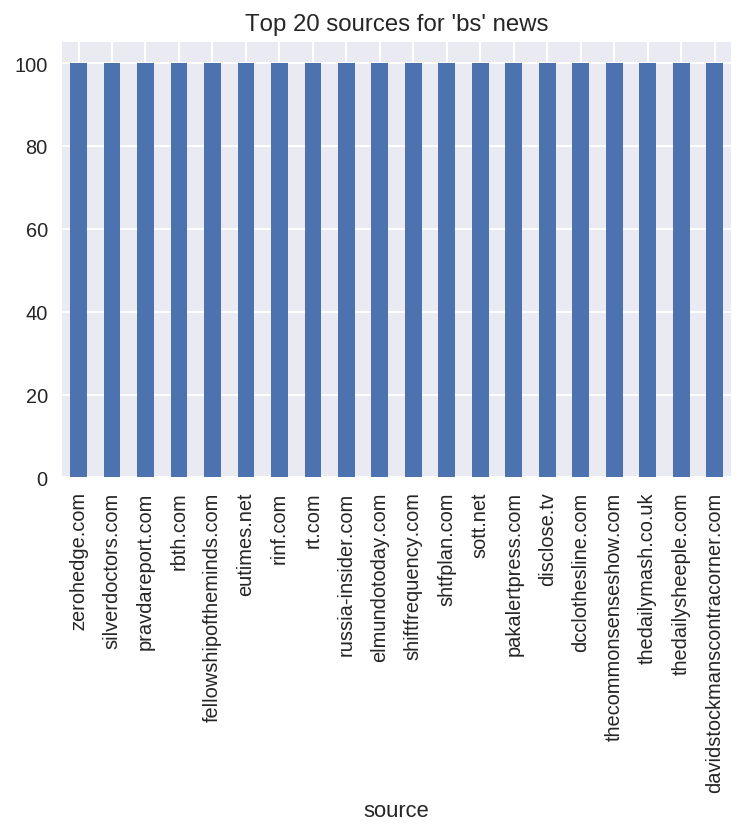

In [21]:
bs_plot=bs.groupby("source")["source"].count().sort_values(ascending=False)[:20].plot(kind="bar")
bs_plot.set_title("Top 20 sources for 'bs' news")
plt.show()

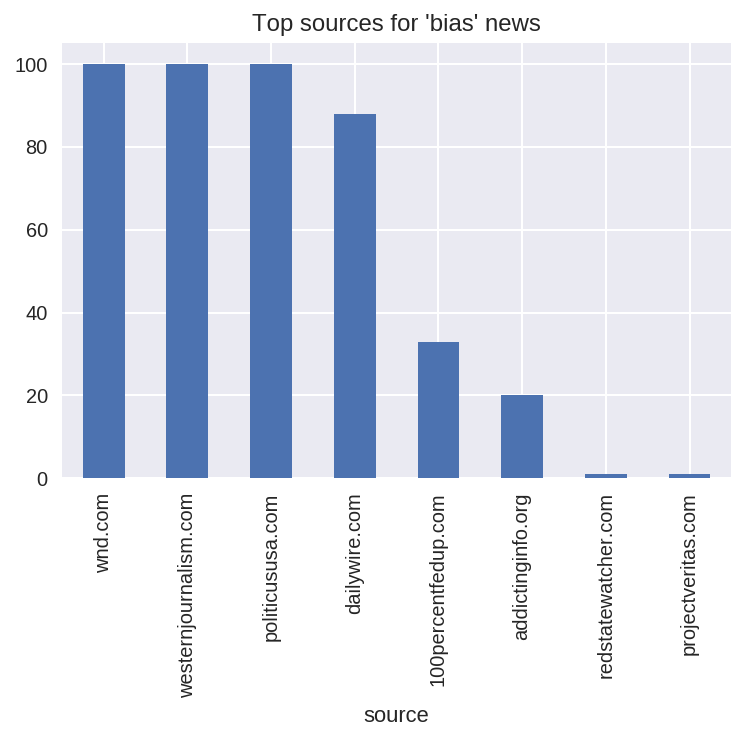

In [22]:
bias_plot=bias.groupby("source")["source"].count().sort_values(ascending=False).plot(kind="bar")
bias_plot.set_title("Top sources for 'bias' news")
plt.show()

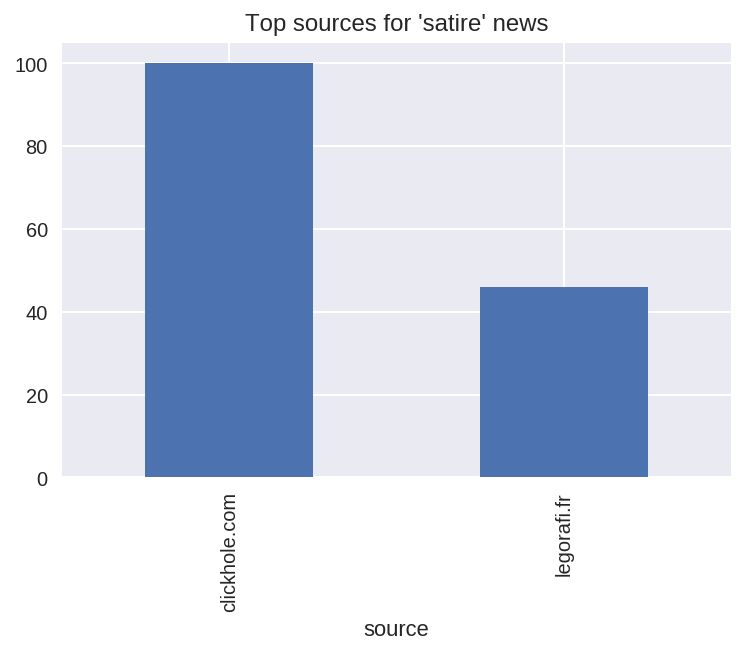

In [23]:
satire_plot=satire.groupby("source")["source"].count().sort_values(ascending=False).plot(kind="bar")
satire_plot.set_title("Top sources for 'satire' news")
plt.show()

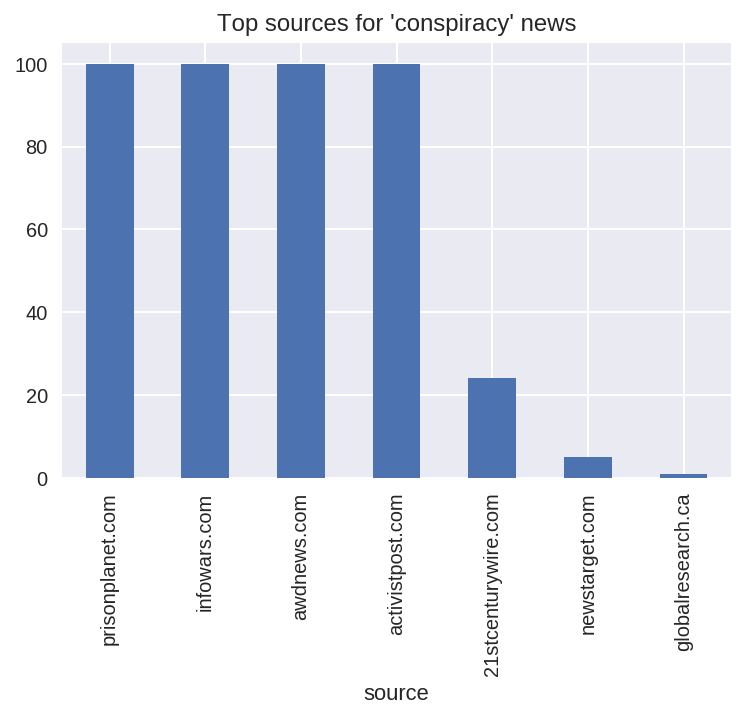

In [24]:
conspiracy_plot=conspiracy.groupby("source")["source"].count().sort_values(ascending=False).plot(kind="bar")
conspiracy_plot.set_title("Top sources for 'conspiracy' news")
plt.show()

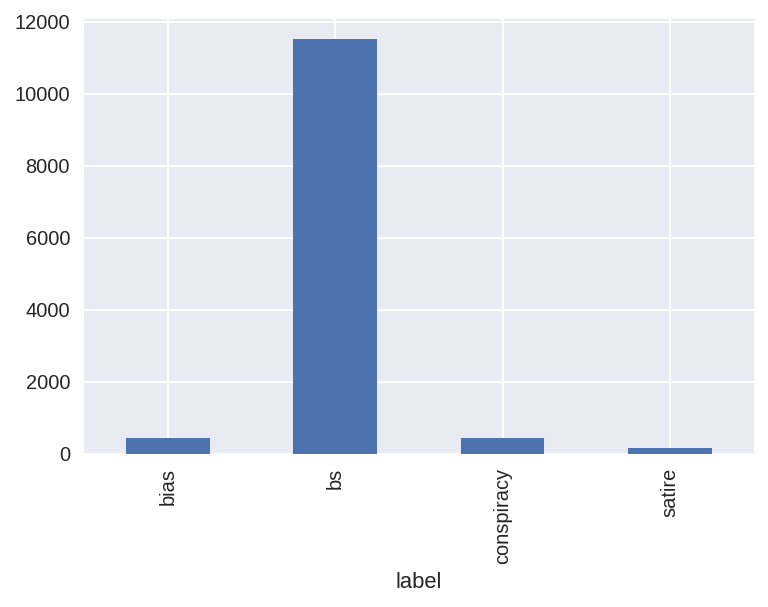

In [25]:
source_sub.groupby("label")["source"].count().plot(kind="bar")

Looks like we definitely have way more "bs" articles than any other category. We need to keep this into account when designing our model 

Overall though it looks like we have distinctions in our sources by label. No sources overlap with any of the labels

#### 2. Time of day's effect on category label

We'll use the kaggle dataset again to look at the time of day and label

In [26]:
time_sub=kaggle_sub[["time", "label"]]

In [27]:
#### Lets look at the number of articles posted in a 24-hour news cycle

In [28]:
time_sub["hour"]=time_sub['time'].dt.hour +1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
time_sub.sample(4)

,time,label,hour
8915,1900-01-01 22:01:00,bs,23
12137,1900-01-01 17:27:00,bs,18
2115,1900-01-01 21:55:00,bs,22
2551,1900-01-01 12:57:00,bs,13


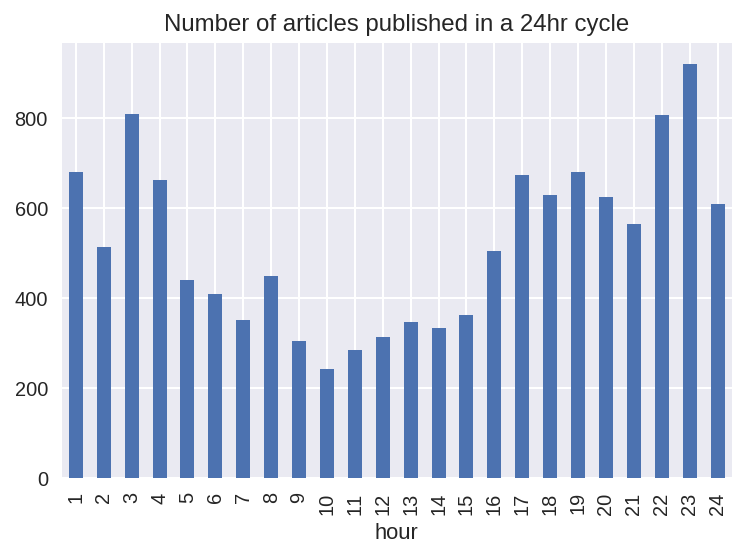

In [30]:
cycle=time_sub.groupby("hour")["hour"].count().plot(kind="bar")
cycle.set_title("Number of articles published in a 24hr cycle")
plt.show()

Lets do the same thing but for each class label

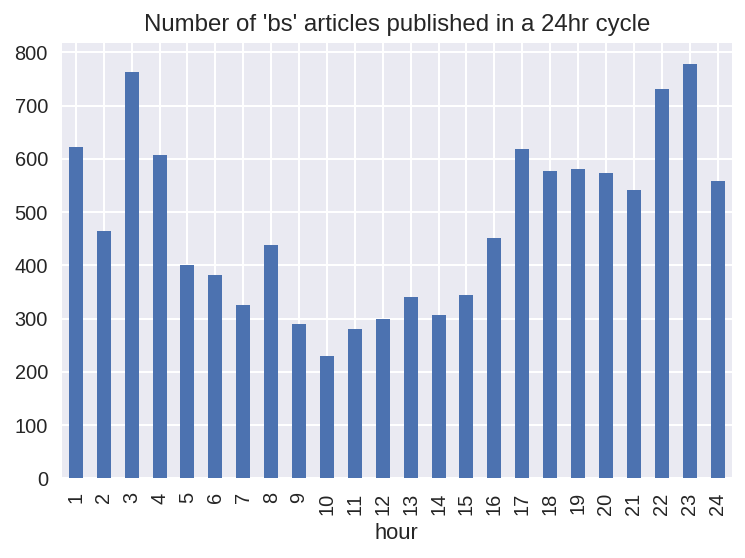

In [31]:
time_sub_bs=time_sub[time_sub["label"]=="bs"]

bs_cycle=time_sub_bs.groupby("hour")["hour"].count().plot(kind="bar")
bs_cycle.set_title("Number of 'bs' articles published in a 24hr cycle")
plt.show()

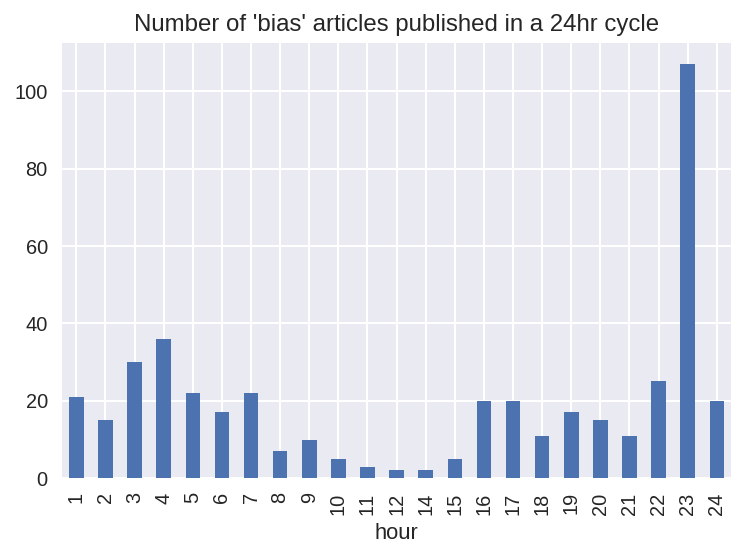

In [32]:
time_sub_bias=time_sub[time_sub["label"]=="bias"]

bias_cycle=time_sub_bias.groupby("hour")["hour"].count().plot(kind="bar")
bias_cycle.set_title("Number of 'bias' articles published in a 24hr cycle")
plt.show()

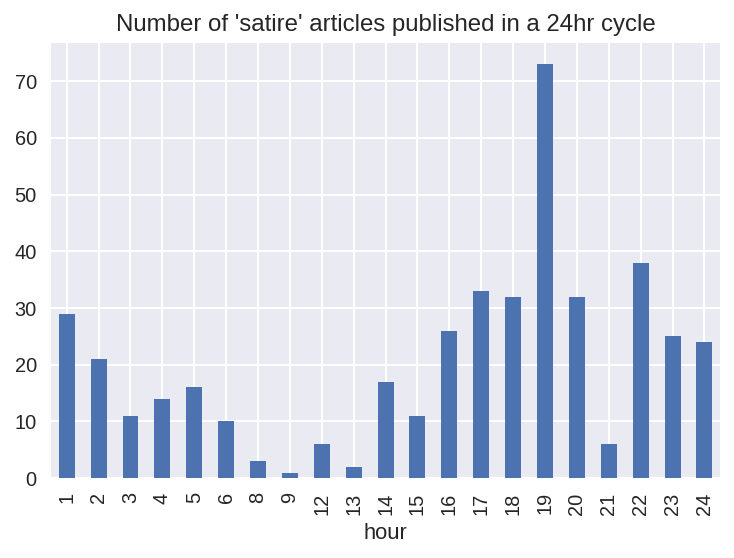

In [33]:
time_sub_satire=time_sub[time_sub["label"]=="conspiracy"]

satire_cycle=time_sub_satire.groupby("hour")["hour"].count().plot(kind="bar")
satire_cycle.set_title("Number of 'satire' articles published in a 24hr cycle")
plt.show()

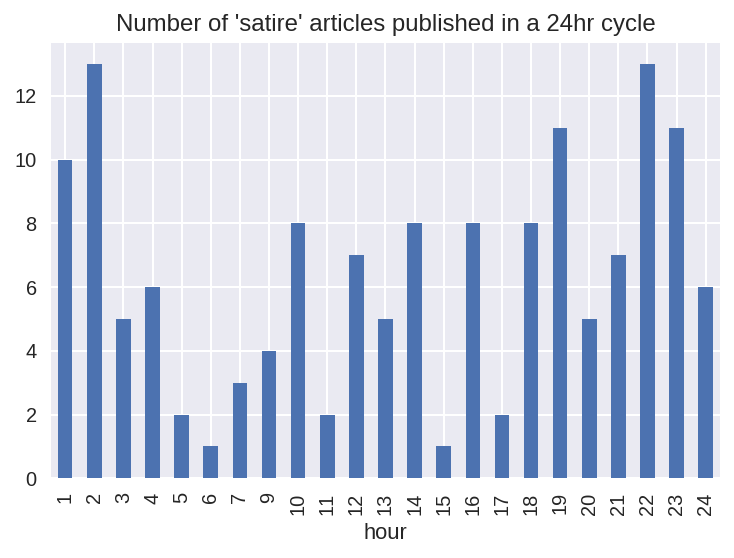

In [34]:
time_sub_conspiracy=time_sub[time_sub["label"]=="satire"]

satire_cycle=time_sub_conspiracy.groupby("hour")["hour"].count().plot(kind="bar")
satire_cycle.set_title("Number of 'satire' articles published in a 24hr cycle")
plt.show()

#### 3. Social media's effect on category labels effect on category label

In [35]:
sm_sub=kaggle_sub[["social_reach_score", "label"]]

#remove those with 0 social reach score
sm_sub = sm_sub[sm_sub["social_reach_score"]>0]
sm_sub.sample(4)

,social_reach_score,label
11149,0.258900,bs
12974,0.420712,bs
1469,1.618123,bs
11133,0.064725,bs


In [36]:
(min(sm_sub["social_reach_score"]), max(sm_sub["social_reach_score"]))

(0.016181229773462785, 5.0)

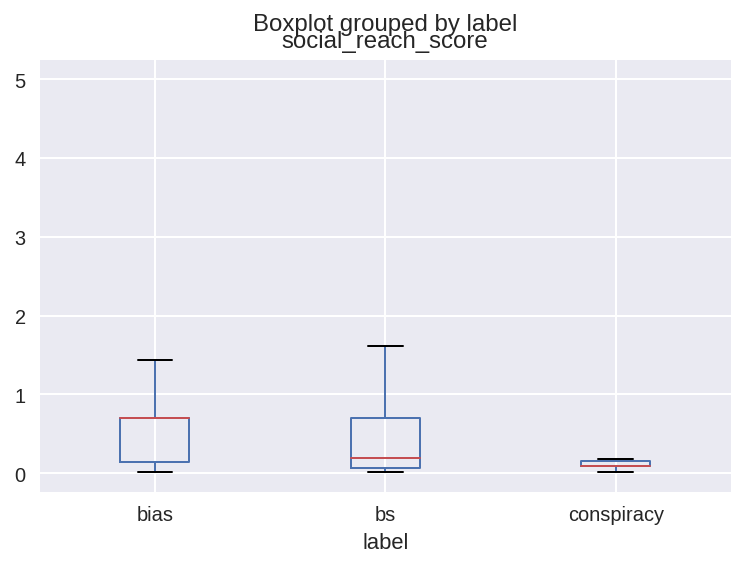

In [37]:
sm_sub.boxplot(column='social_reach_score', by='label')
plt.show()

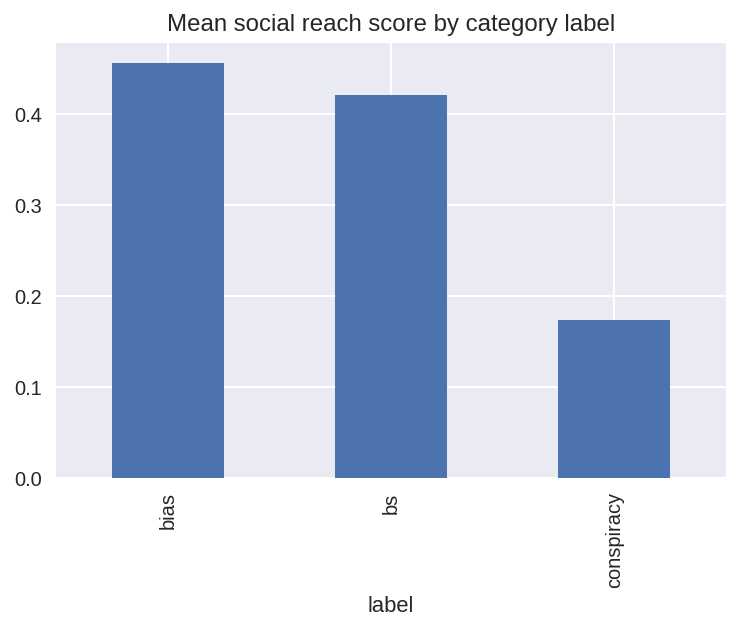

In [38]:
sm_plot= sm_sub.groupby("label")["social_reach_score"].mean().plot(kind="bar")
sm_plot.set_title("Mean social reach score by category label")
plt.show()

#### 4. Token Analysis with labels

We will analyze both the McIntire and kaggle datasets' tokens using a TokenAnalysis class I constructed. 


Part 4 will do a TokenAnalysis on the McIntire set with their "REAL"/"FAKE" labels, while Part 5 will analyze tokens with their labels from the kaggle dataset at specified time ranges to try to account for current events that occurred in that timeframe

In [39]:
class TokenAnalysis(object):
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    
    
    def __init__(self, df, Vectorizer=None, max_df=None, n_gram_range=None, stop_words=None):
        '''Initialize default attributes for class and vectorize text'''
        
        self.text=df["text"]
        self.label=df["label"]
        
        self.max_df=max_df
        self.ngram_range= n_gram_range
        self.vec=Vectorizer

        
        if stop_words is None:
            self.stop_words=list(ENGLISH_STOP_WORDS)           
        else:
            self.stop_words= stop_words
        
        
        if self.vec is None:
            if self.max_df is None:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=0.7) 
            else:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=self.max_df)
                
        else:                    
            if self.ngram_range is None:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7)
            else:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7, ngram_range=self.ngram_range)
        

        
    
        # make token dataframe called X_text
        self.X = self.vectorizer.fit_transform(self.text)
        self.X_text = pd.DataFrame(self.X.toarray(), columns = self.vectorizer.get_feature_names())
        self.X_text.index=self.label
    
        
    def top_tokens(self, num=None, label=None):
        '''returns top tokens by number of tokens and/or label'''
        if num is None and label is None:
            token_sum = self.X_text.sum()
            top=token_sum.sort_values(ascending=False)
            return top[:10]
        
        if label is None:
            token_sum = self.X_text.sum()
            top=token_sum.sort_values(ascending=False)
            return top[:num]
        
        else:
            token_sums_labeled = self.X_text[self.X_text.index==label].sum()
            top=token_sums_labeled.sort_values(ascending=False)
            
            if num is None:
                return top[:10]
            else:
                return top[:num] 
            
            
            
    def top_tokens_label_freq(self, num=None):
        '''returns tokens grouped by category label'''
        if num is None:
            num=10
            
        top=self.top_tokens(num)
        return self.X_text.groupby(self.X_text.index)[top.index[:num]].sum()                                                      

    
    def plot_top_tokens(self, num=None, label=None):
        '''plots top tokens'''
        top=self.top_tokens(num, label)
     
        if label is None:
            label="GLOBAL"
        
        plt.figure(figsize=(8,6))
        
        plot1=sns.barplot(x=top.index, y=top)
        
        plot1.set_title("Top {} {} tokens".format(len(top), label))
        plot1.set_xticklabels(top.index, rotation=30)
        plt.show()
        
        
        
    def plot_top_tokens_by_binary_label(self, num=None):
        '''plots top tokens for binary classes'''
        labeled_df=self.top_tokens_label_freq(num).T
        labels=list(labeled_df.columns)
        ylim=max(max(self.top_tokens(label=labels[0])), max(self.top_tokens(label=labels[1])))
        
        fig, ax = plt.subplots(1, len(labels), figsize=(15, 8))

        for axes in range(len(labels)):
            label=labels[axes]
            plot=labeled_df[label].plot(kind="bar", ax=ax[axes])
            plot.set_xticklabels(labeled_df.index, rotation=30)
            ax[axes].set_title("Freq of top tokens in {} Articles".format(label))
            ax[axes].set_ylim([0,ylim*1.10])
        
        plt.show()
        
        
    
    def plot_top_tokens_by_label(self, num=None):
        '''plots top tokens for multinomial classes'''
        
        labeled_df=self.top_tokens_label_freq(num).T
        labels=list(labeled_df.columns)
        ylim=0
        
        for i in range(len(labels)):
            if labels[i] != "bs":
                ylim= max(ylim, max(self.top_tokens(label=labels[i])))
        
        fig, ax = plt.subplots(len(labels), 1, figsize=(6, 30))

        for axes in range(len(labels)):
            label=labels[axes]
            plot=labeled_df[label].plot(kind="bar", ax=ax[axes])
            plot.set_xticklabels(labeled_df.index, rotation=30)
            ax[axes].set_title("Freq of top tokens in {} Articles".format(label))
            if label!="bs":
                ax[axes].set_ylim([0,ylim*1.10])

        
        plt.show()
        
        
        
    def add_stops(self, words):
        '''add stop words to stopwords attibutes and revectorizes document with new stop words'''
        if type(words) is list:
            self.stop_words.extend(words)
        else:
            self.stop_words.append(words)
        

        if self.vec is None:
            if self.max_df is None:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=0.7) 
            else:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=self.max_df)
                
        else:                    
            if self.ngram_range is None:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7)
            else:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7, ngram_range=self.ngram_range)
        
        
        self.X = self.vectorizer.fit_transform(self.text)
        self.X_text = pd.DataFrame(self.X.toarray(), columns = self.vectorizer.get_feature_names())
        self.X_text.index=self.label
        
        
        
        

First we'll look at the McIntire dataset with a CountVectorizer. A CountVectorizer will vectorizer the one word tokens with their frequency. 

The hyperparameter max_df defaults to 0.7 when I instantiate my class. max_df lets you set a threshold amount of token you want to omit across articles I chose this value because I want to omit tokens that appear in more than 70% of the articles

In [40]:
#Instansiate TokenAnalysis object with Countvectorizer using a sample 1000 entries from the dataset
CV_1 = TokenAnalysis(McIntire.sample(1000))

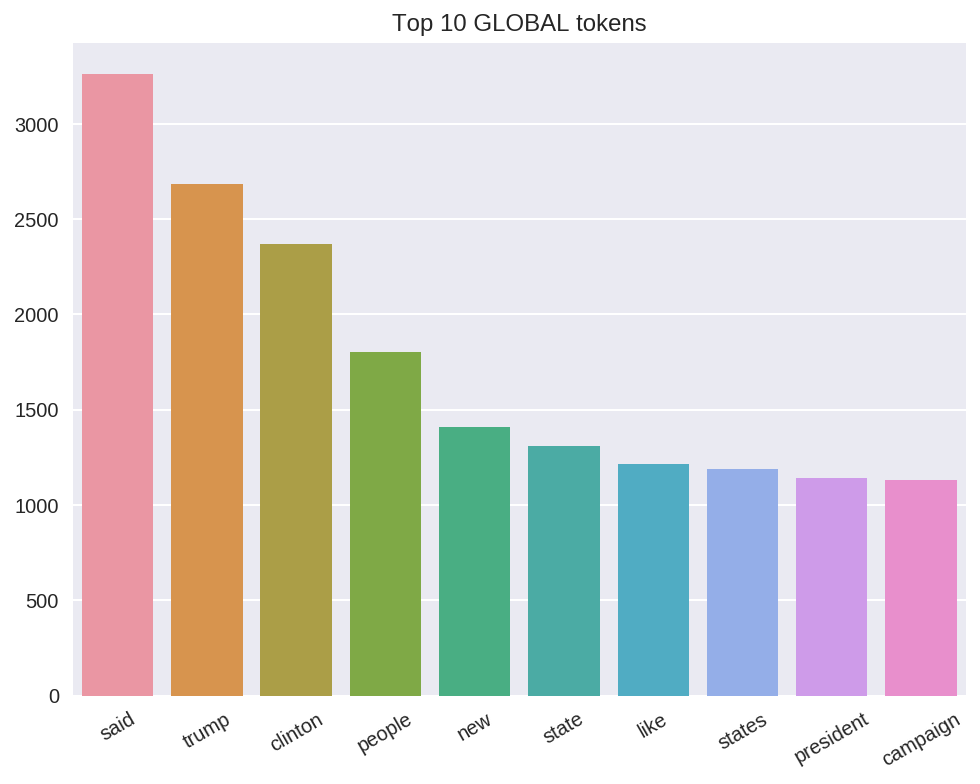

In [41]:
# Top 10 GLOBAL tokens
CV_1.plot_top_tokens()

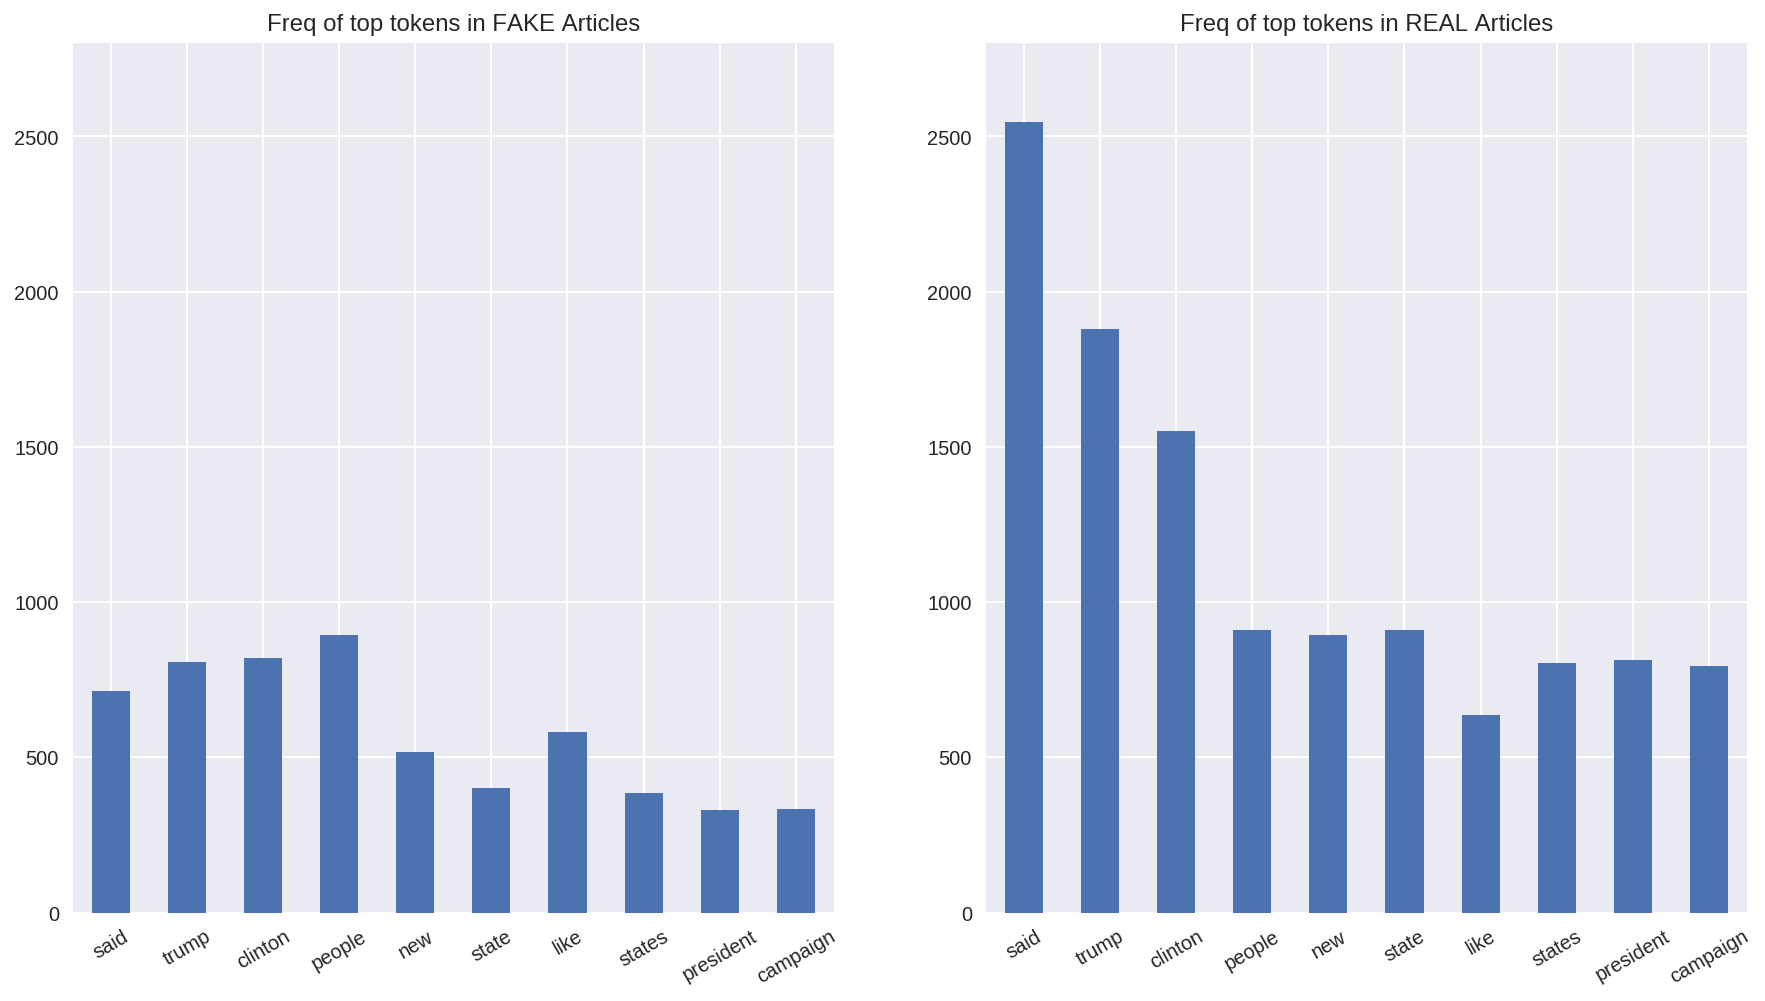

In [42]:
# Top 10 GLOBAL tokens for each label
CV_1.plot_top_tokens_by_binary_label()

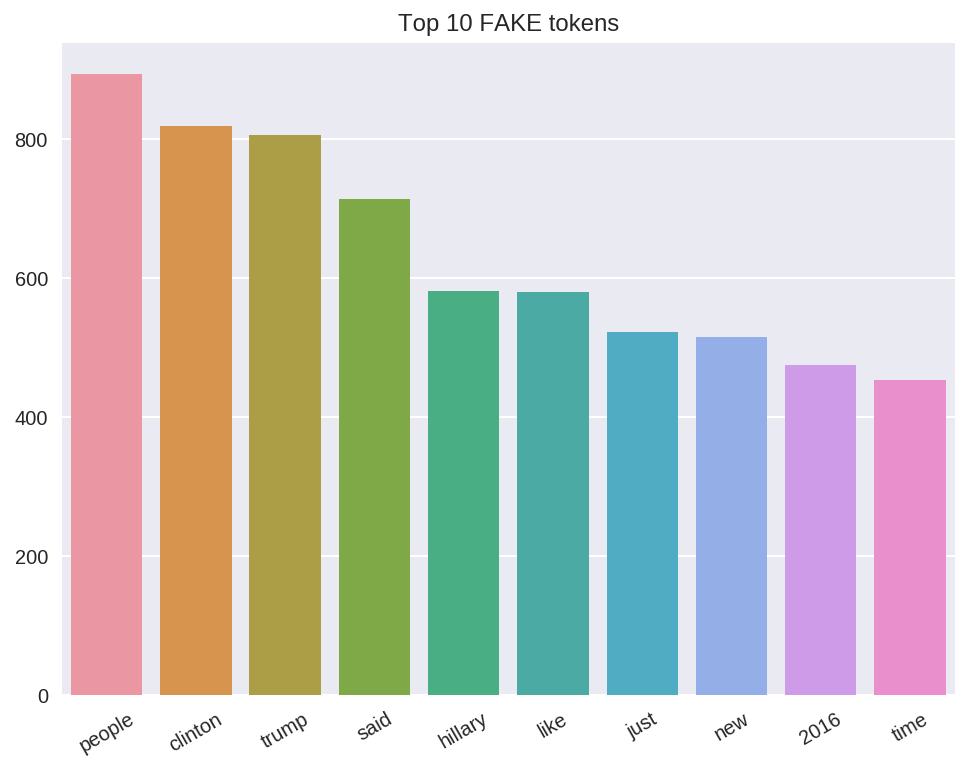

In [43]:
# Top 10 FAKE tokens
CV_1.plot_top_tokens(label="FAKE")

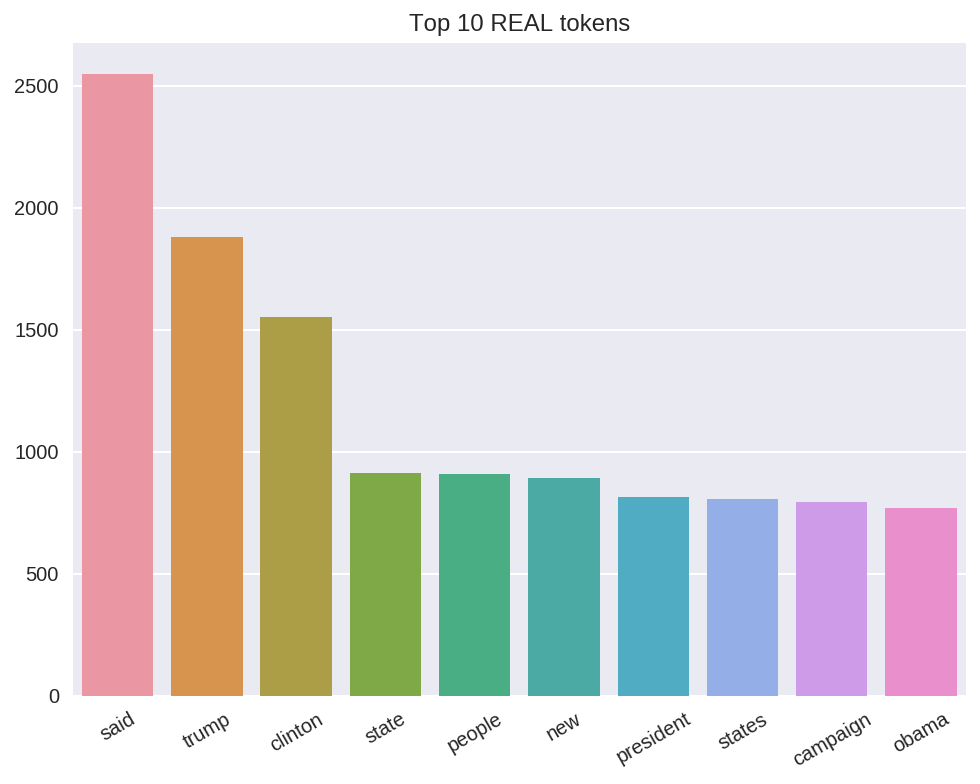

In [44]:
# Top 10 REAL tokens
CV_1.plot_top_tokens(label="REAL")

Next let's vectorize the text with a TfidfVectorizer with token n_gram ranges 2, 3 and 6.

TfidfVectorizers are useful because they scale term frequency counts in each document by penalising terms that appear more widely across the entire corpus. This allows us to determine the most important words in each document, account for words shared in the documents besides the stop words, and make sure that the most common words don't show up as key words by downwieghting their value.

The ngram range refers to the length we want each token to be in each vector. We will most like get the most value from 1 to 3 token ngrams but it will be interesting to see if their is any distinction between classes for longer ngrams

In [45]:
TF_2_ngram = TokenAnalysis(McIntire.sample(1000), TfidfVectorizer, n_gram_range=(2,2))
TF_3_ngram = TokenAnalysis(McIntire.sample(1000), TfidfVectorizer, n_gram_range=(3,3))
TF_6_ngram = TokenAnalysis(McIntire.sample(1000), TfidfVectorizer, n_gram_range=(6,6))

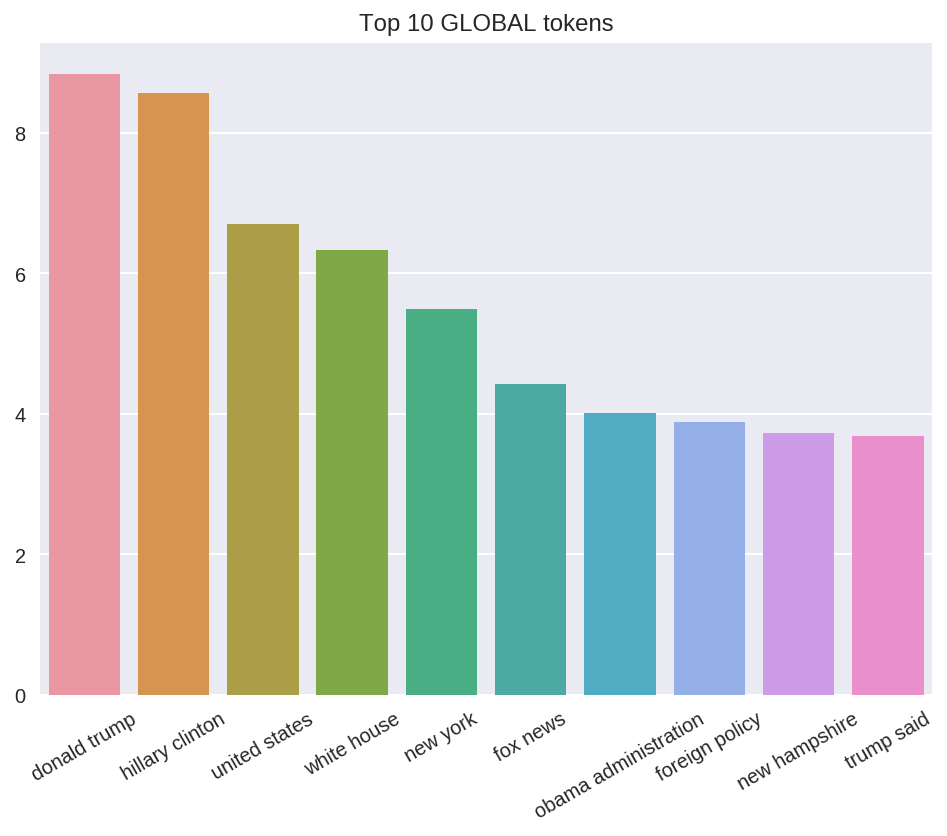

In [46]:
# Top 10 GLOBAL tokens
TF_2_ngram.plot_top_tokens()

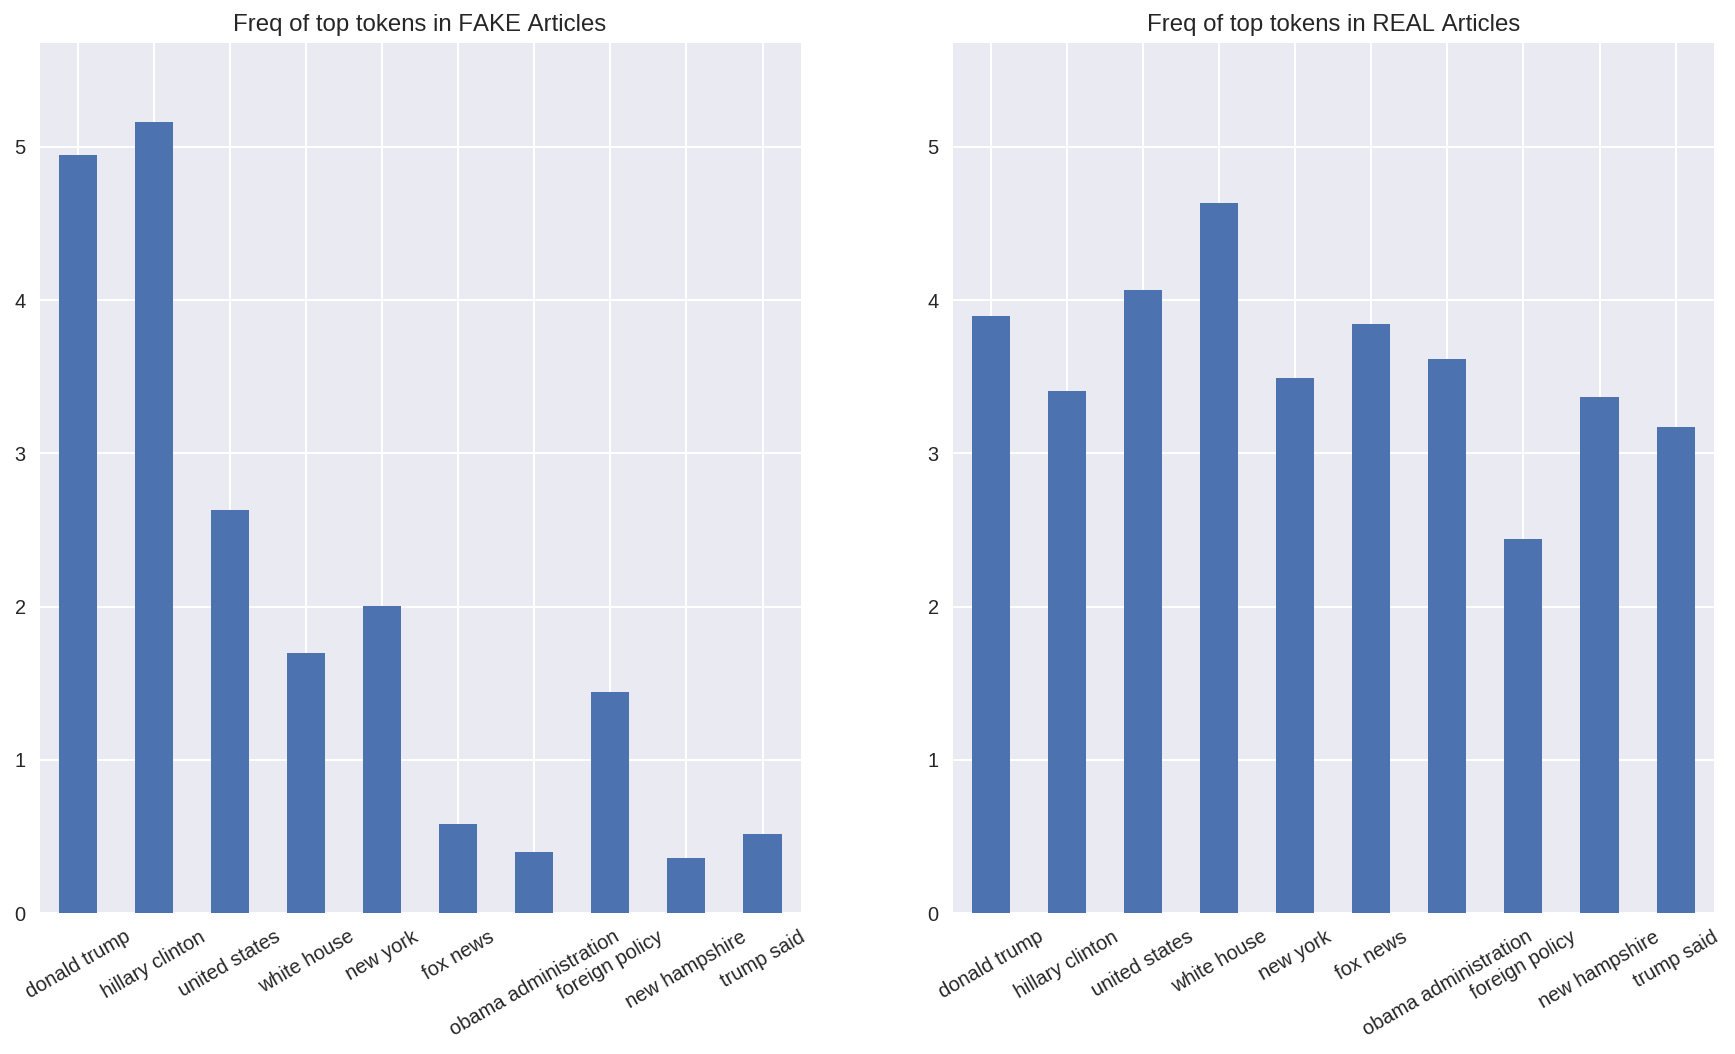

In [47]:
# Top 10 GLOBAL tokens for each label
TF_2_ngram.plot_top_tokens_by_binary_label()

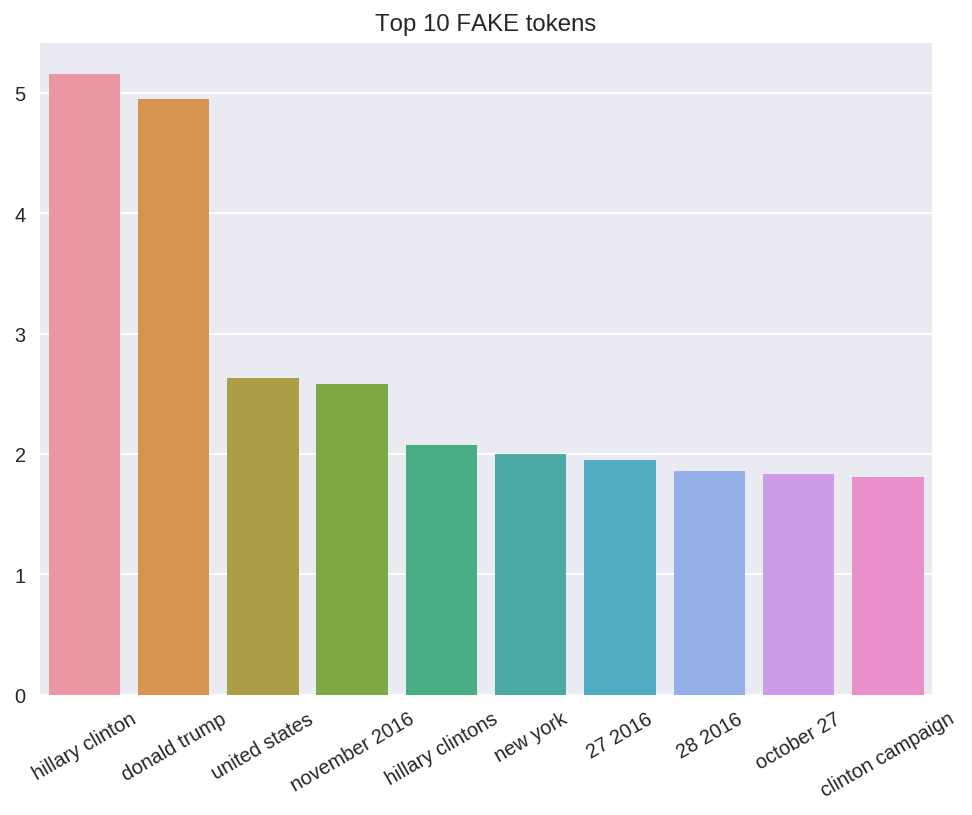

In [48]:
# Top 10 FAKE tokens
TF_2_ngram.plot_top_tokens(label="FAKE")

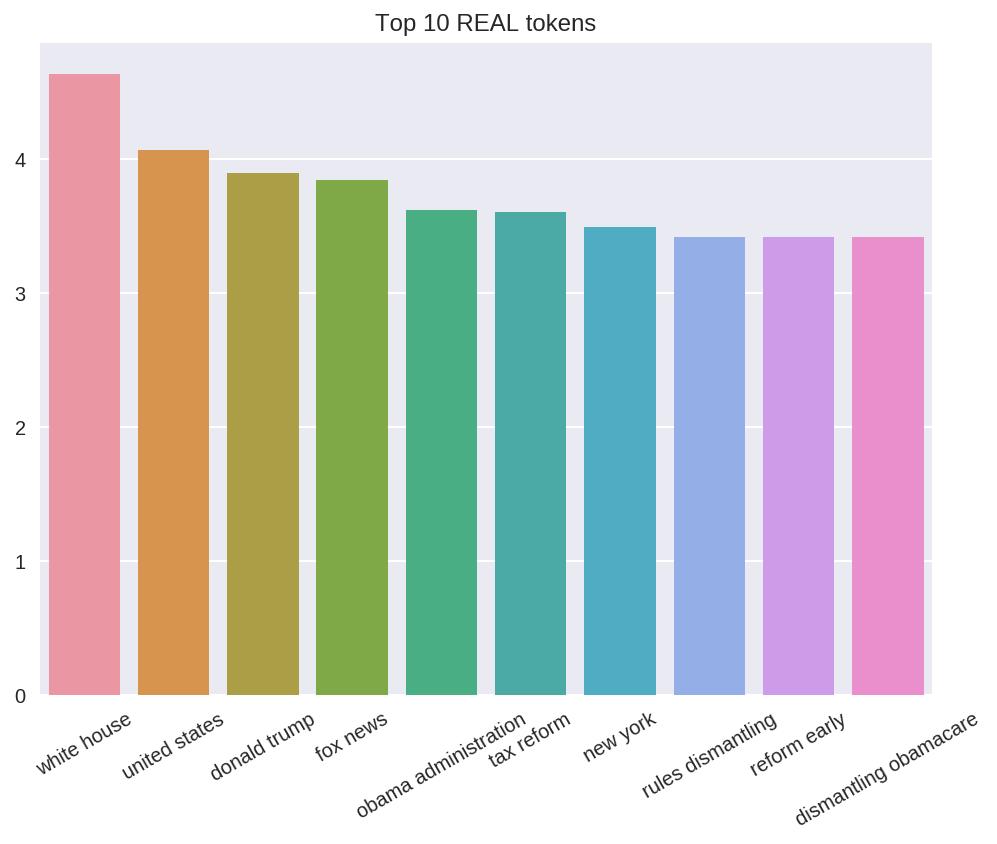

In [49]:
# Top 10 REAL tokens
TF_2_ngram.plot_top_tokens(label="REAL")

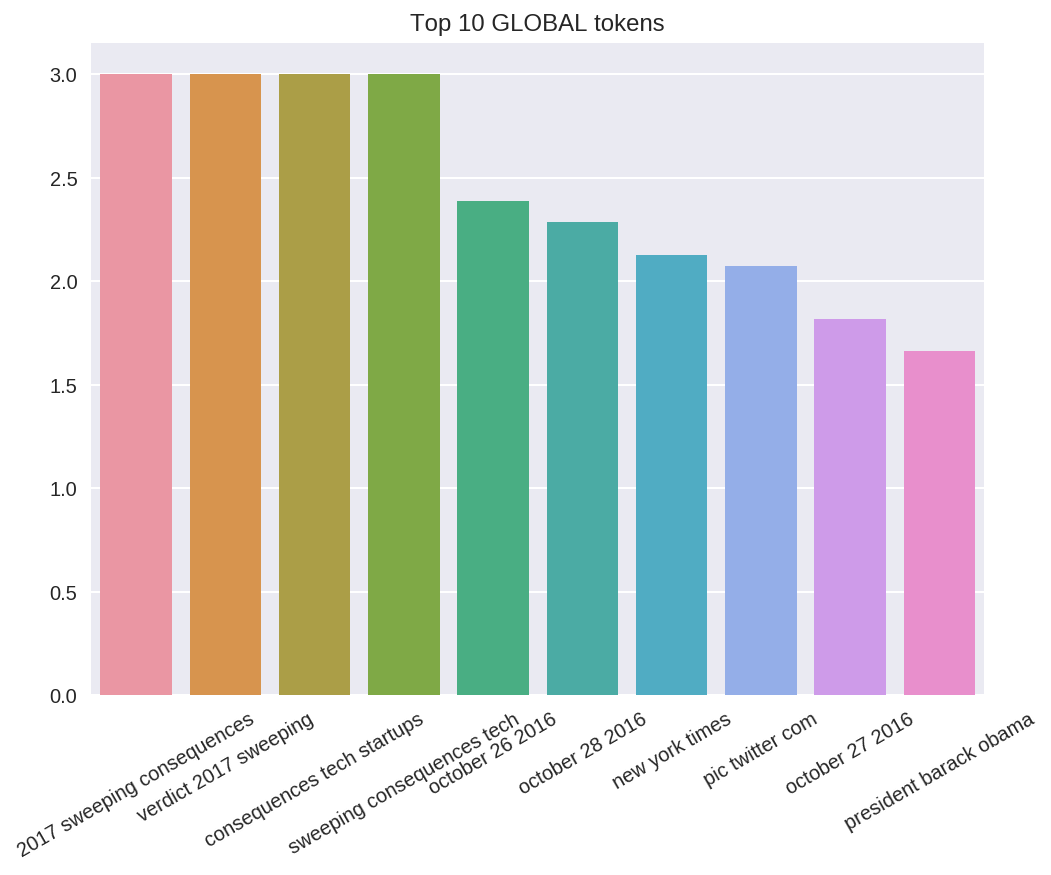

In [50]:
# Top 10 GLOBAL tokens
TF_3_ngram.plot_top_tokens()

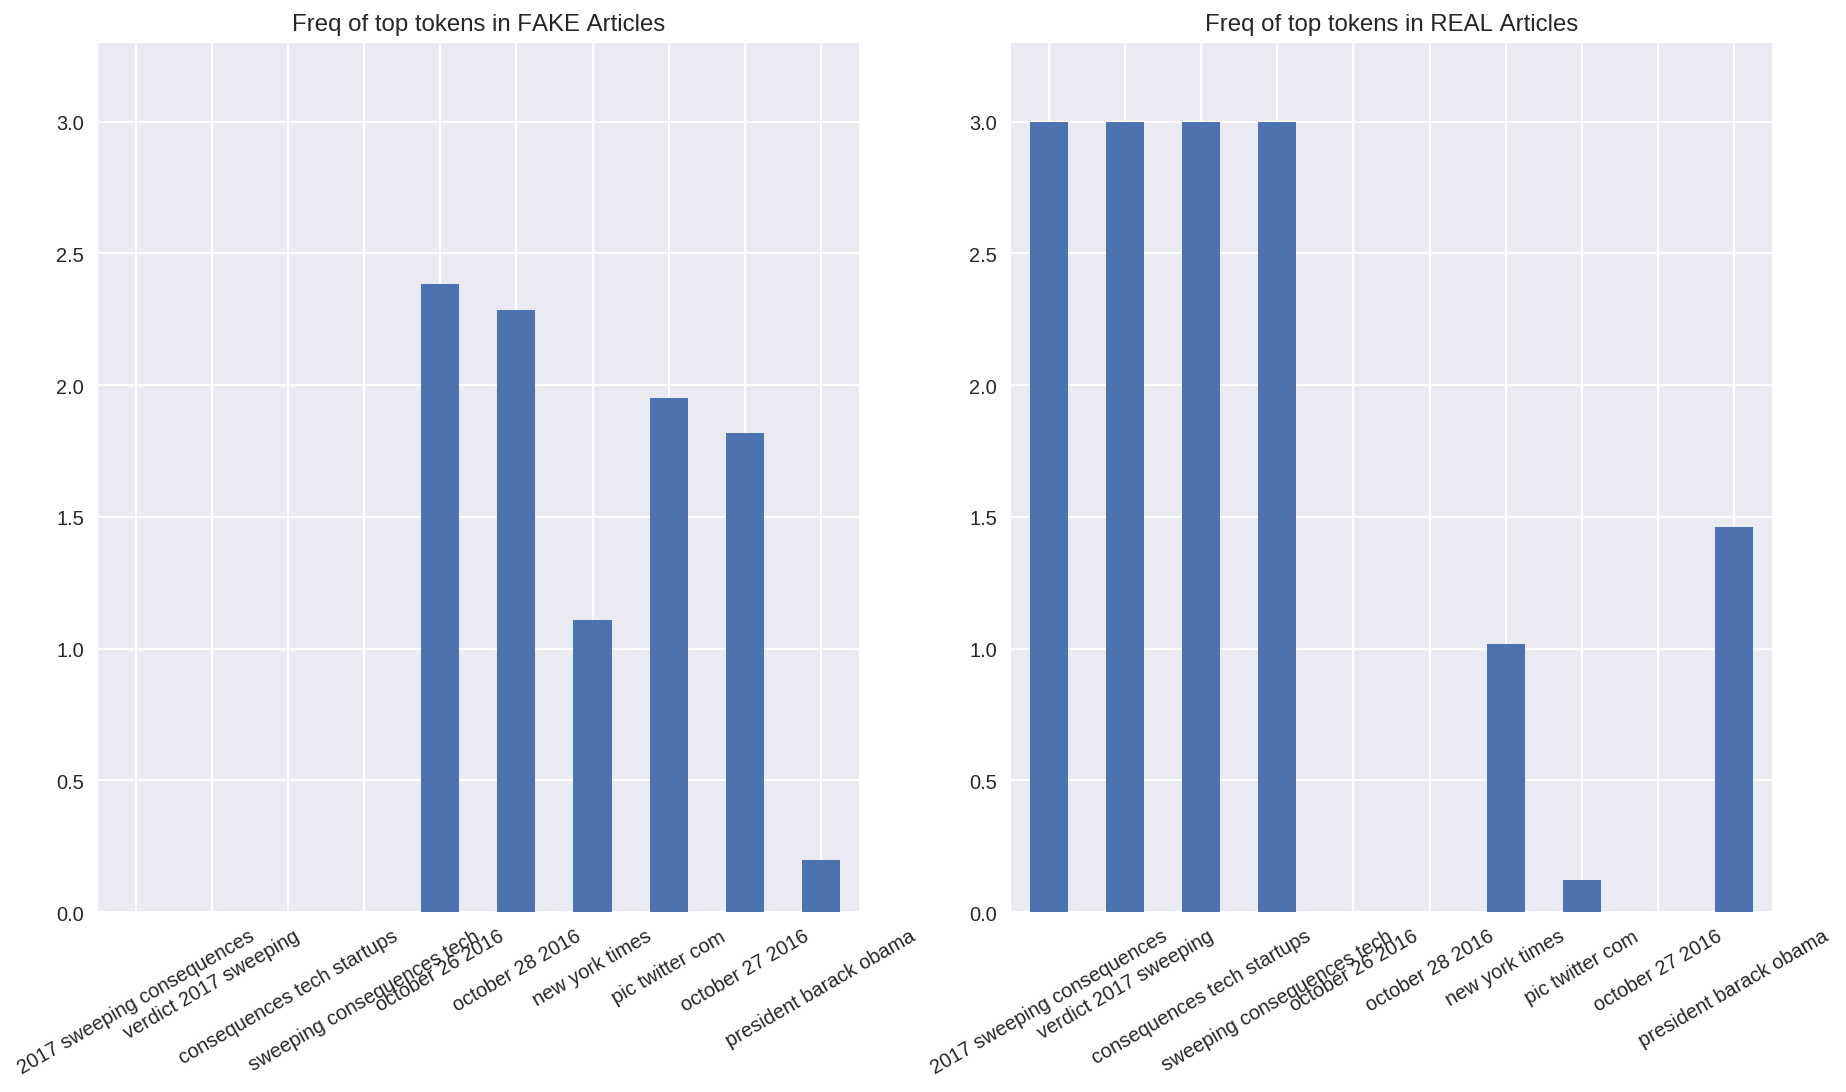

In [51]:
# Top 10 GLOBAL tokens for each label
TF_3_ngram.plot_top_tokens_by_binary_label()

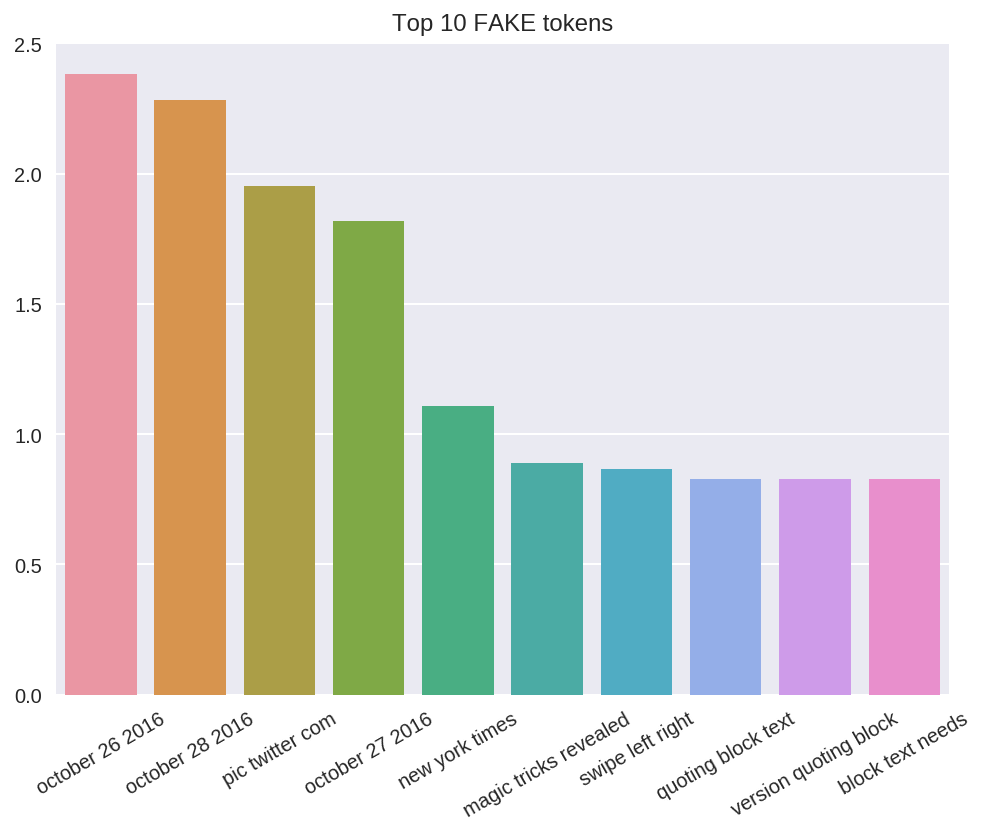

In [52]:
# Top 10 FAKE tokens
TF_3_ngram.plot_top_tokens(label="FAKE")

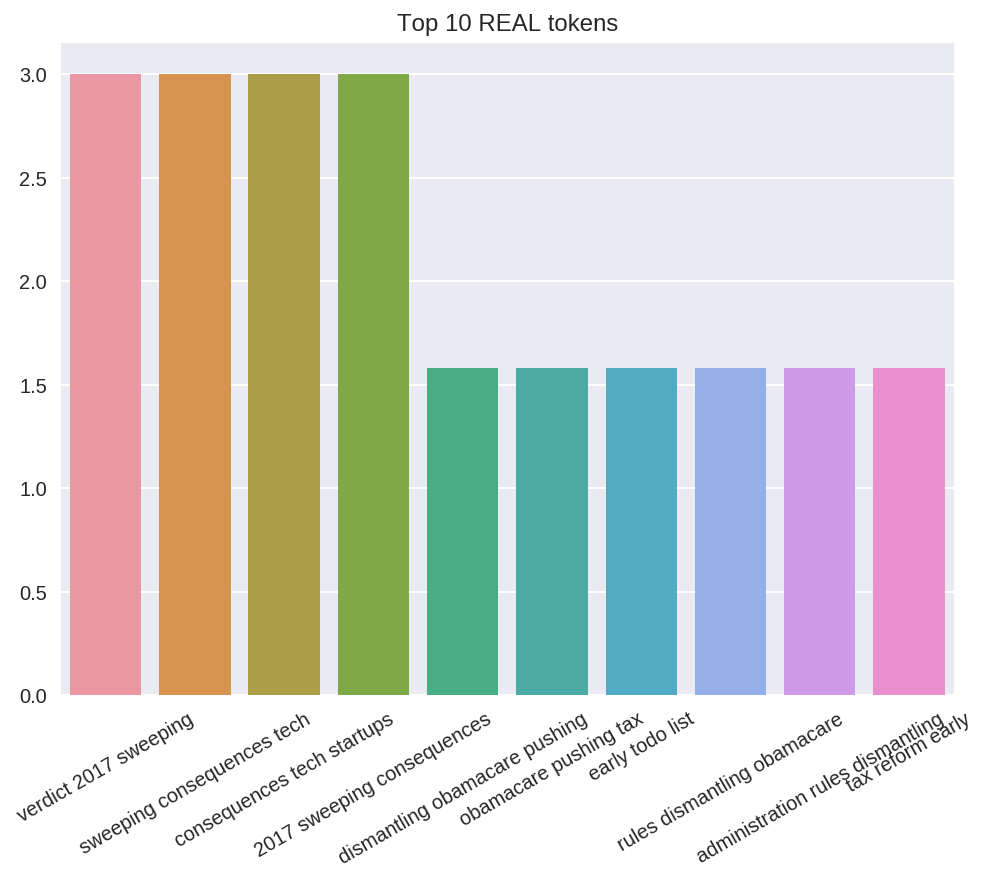

In [53]:
# Top 10 REAL tokens
TF_3_ngram.plot_top_tokens(label="REAL")

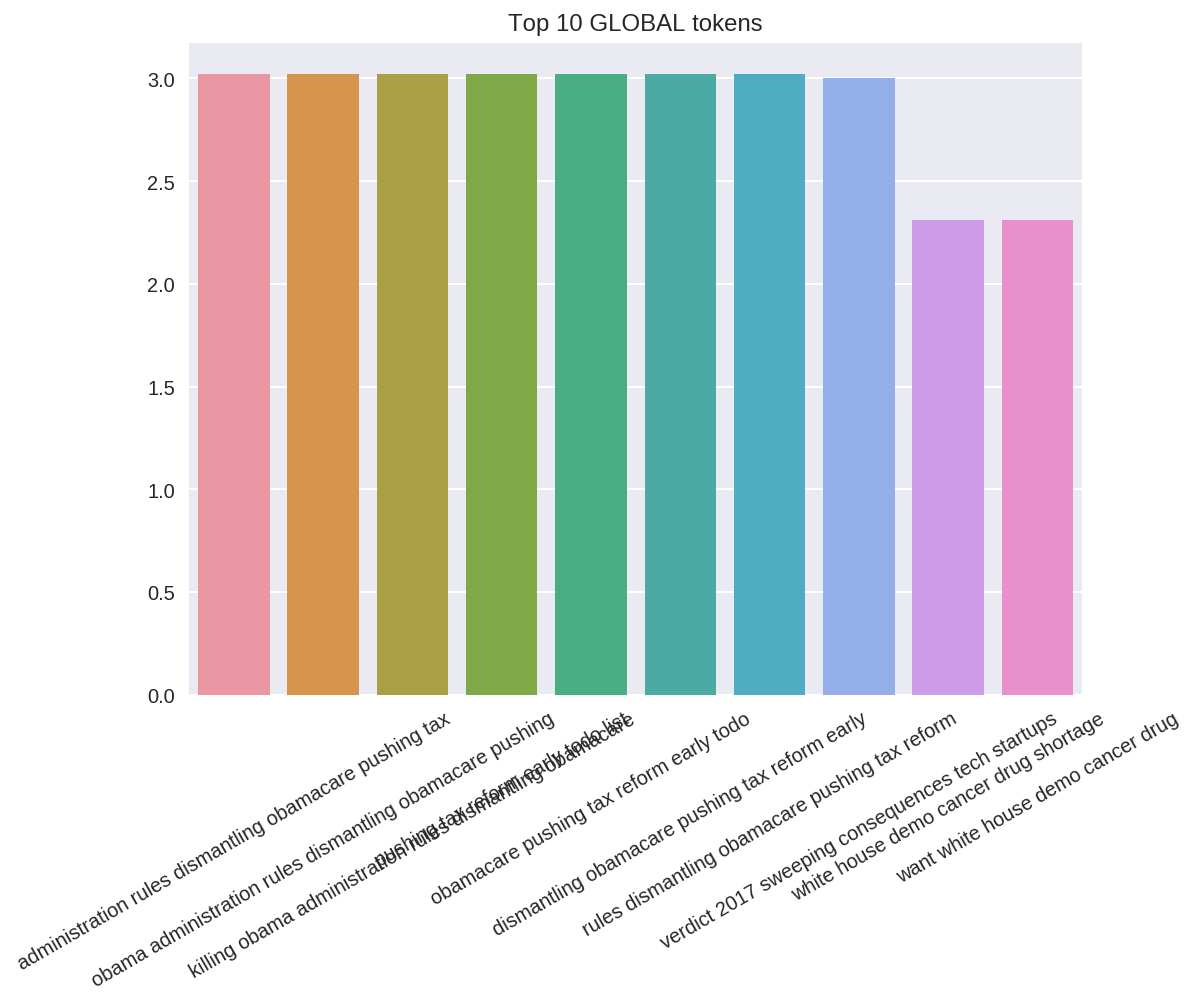

In [54]:
# Top 10 GLOBAL tokens
TF_6_ngram.plot_top_tokens()

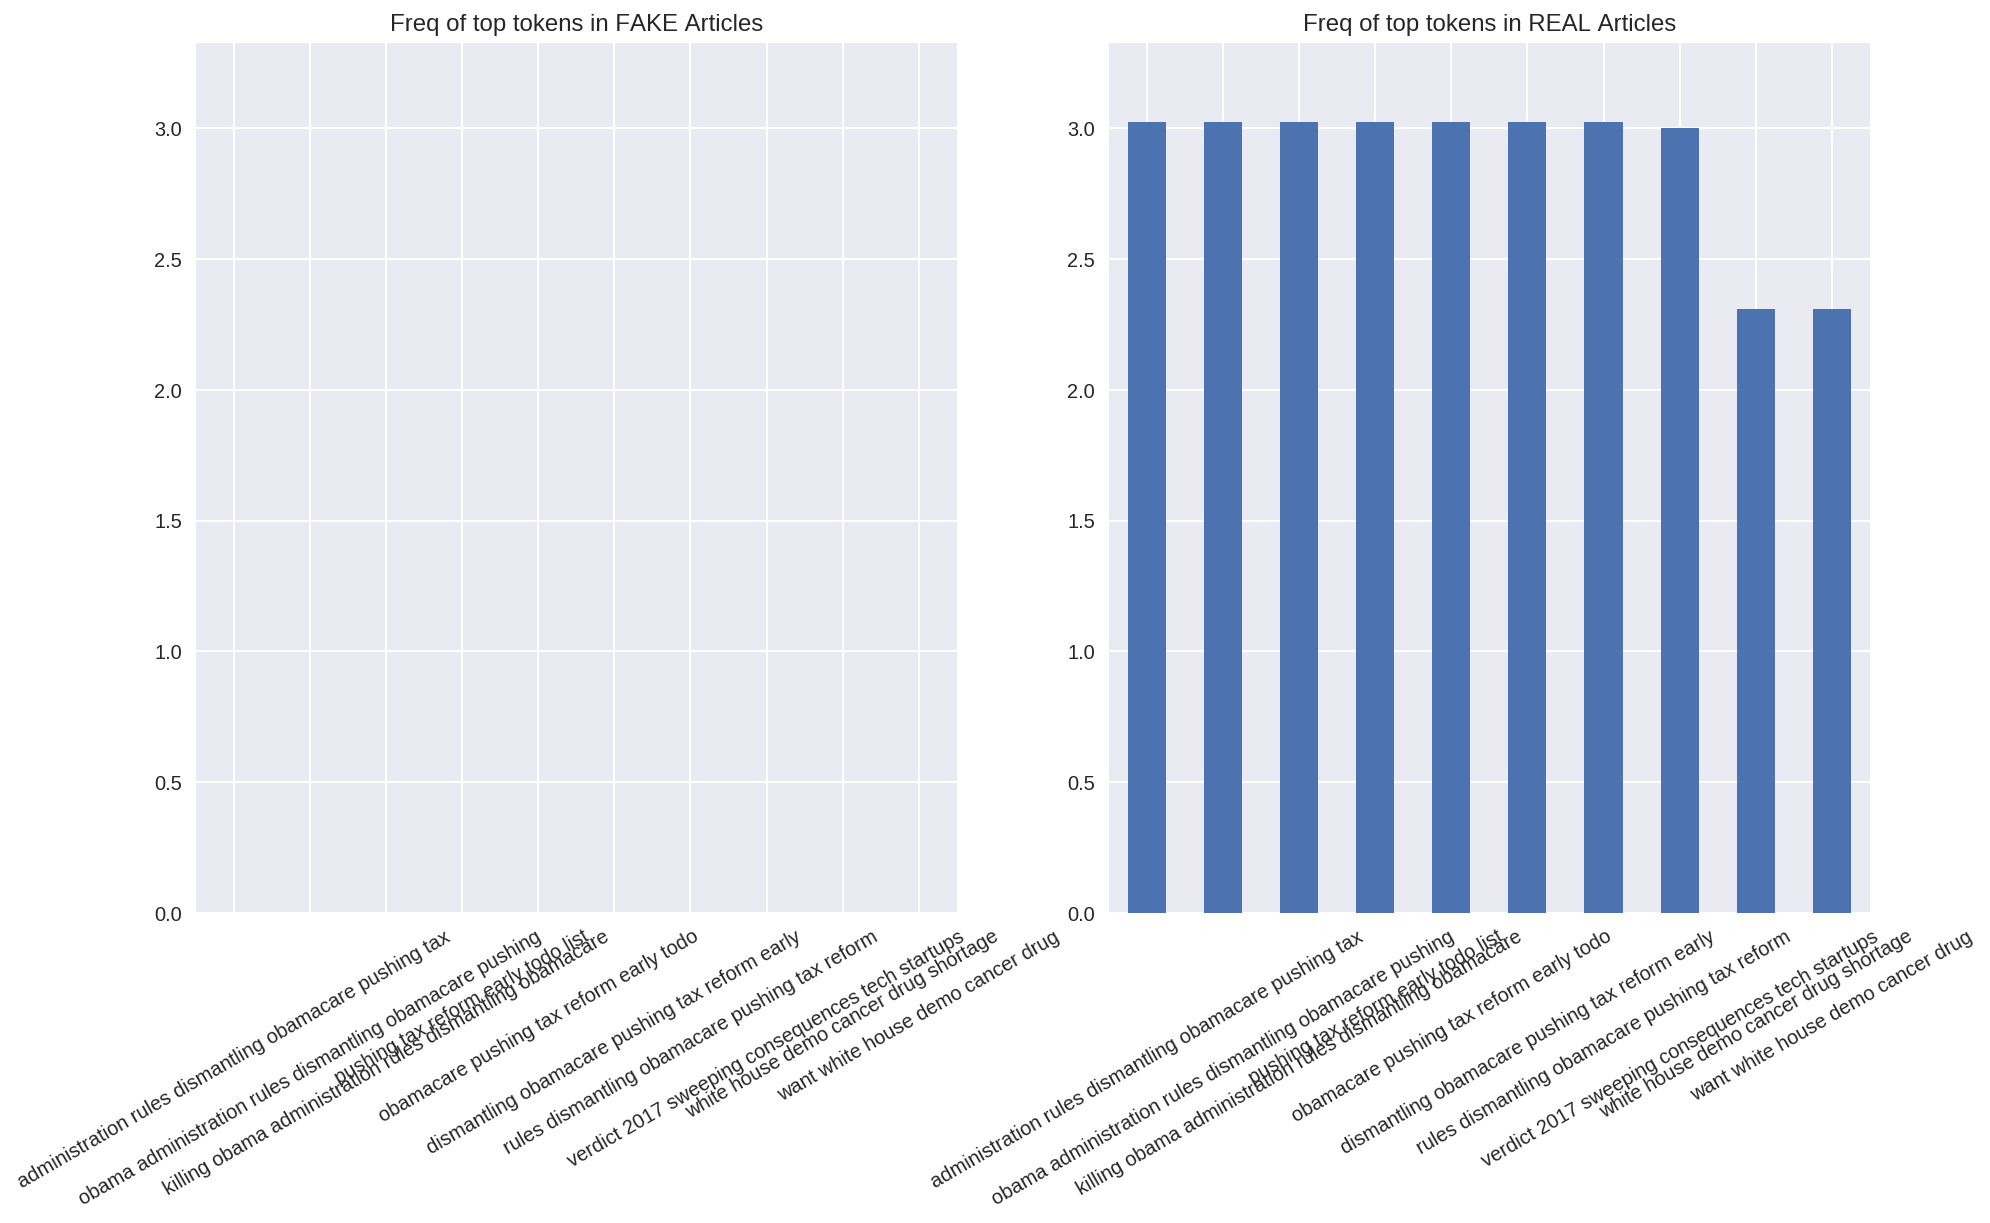

In [55]:
# Top 10 GLOBAL tokens for each label
TF_6_ngram.plot_top_tokens_by_binary_label()

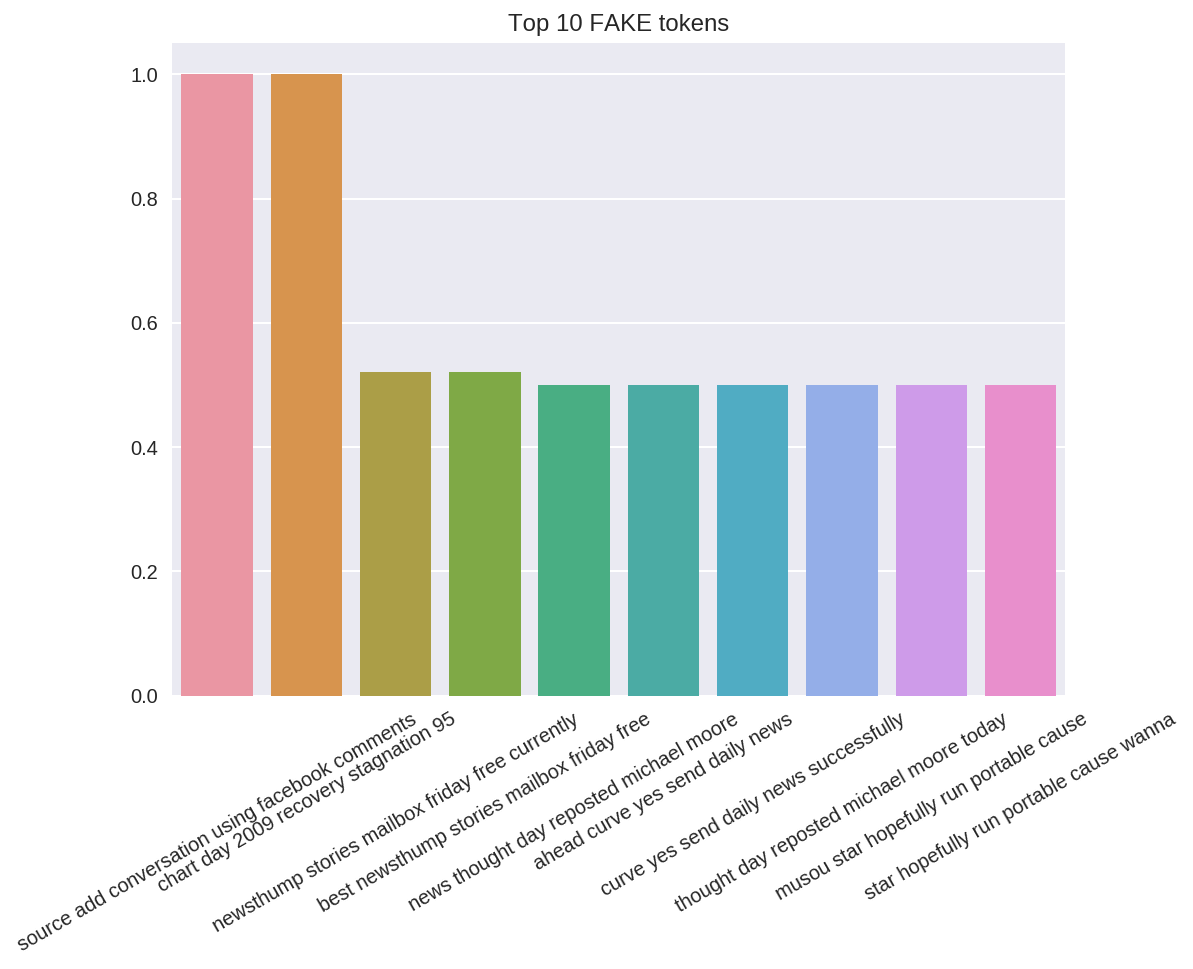

In [56]:
# Top 10 FAKE tokens
TF_6_ngram.plot_top_tokens(label="FAKE")

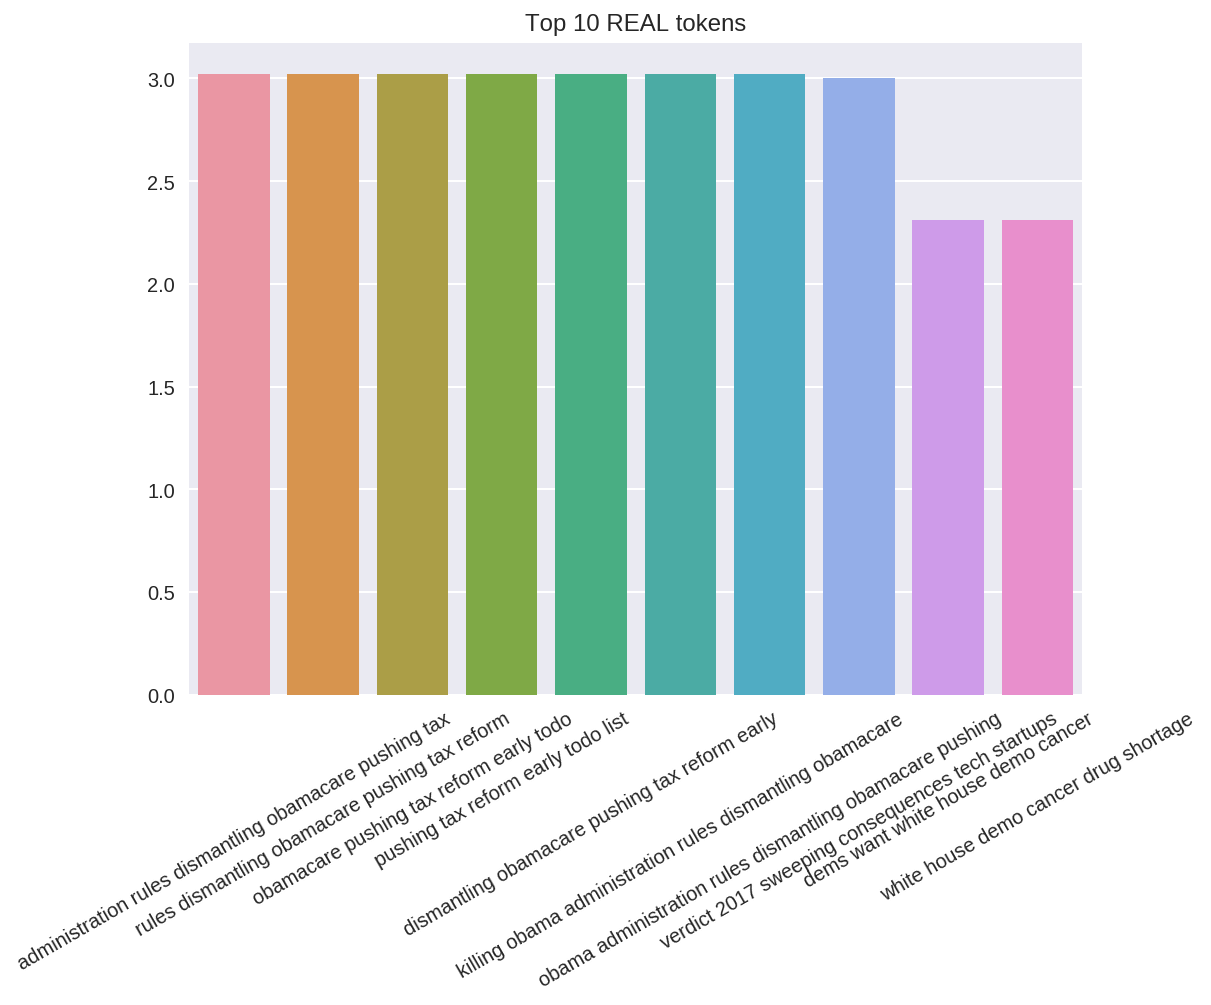

In [57]:
# Top 10 REAL tokens
TF_6_ngram.plot_top_tokens(label="REAL")

#### 5. Kaggle Token Analysis with labels for specified time ranges

I specified 4 date ranges that occured between 10-26-2016 and 11-25-2016 that I think would be of note to analyze:

1. Before October 28- the date FBI director James Comey released a letter to Congress indicating the would reopen the case concerning Hillary Clinton's private email server
2. October 28 - November 7- Comey letter and backlass to right before Election Day
3. November 8 - November 9- Election Day to last poll closing
4. November 10 - November 25- After the election to the end of the dataset

In [58]:
# We'll makre label the data as either "bs" or "not_bs"
kaggle.loc[kaggle['label'] != "bs", 'label'] = "not_bs"

In [59]:
kaggle['label'].value_counts().unique

<bound method Series.unique of bs        11511
not_bs     1488
Name: label, dtype: int64>

In [60]:
before_comey_mask=kaggle["date"]<'2016-10-28 00:00:00'
comey_mask=(kaggle["date"]>='2016-10-28 00:00:00' )& (kaggle["date"]<'2016-11-08 00:00:00')
election_mask=(kaggle["date"]>='2016-11-08 00:00:00' )& (kaggle["date"]<'2016-11-10 00:00:00')
after_election_mask=kaggle["date"]>='2016-11-10 00:00:00' 

bc_df = kaggle[before_comey_mask]
comey_df = kaggle[comey_mask]
election_df = kaggle[election_mask]
ae_df = kaggle[after_election_mask]

We'll use a TfidfVectorizer with n_gram range 1 to 2 on each timeframe and analyze ther respective tokens

In [61]:
TF_1_ngram_bc = TokenAnalysis(bc_df, TfidfVectorizer)
TF_2_ngram_bc = TokenAnalysis(bc_df, TfidfVectorizer, n_gram_range=(2,2))

In [ ]:
TF_1_ngram_comey = TokenAnalysis(comey_df, TfidfVectorizer)
TF_2_ngram_comey = TokenAnalysis(comey_df, TfidfVectorizer, n_gram_range=(2,2))

In [83]:
TF_1_ngram_election = TokenAnalysis(election_df, TfidfVectorizer)
TF_2_ngram_election = TokenAnalysis(election_df, TfidfVectorizer, n_gram_range=(2,2))

In [ ]:
TF_1_ngram_ae = TokenAnalysis(ae_df, TfidfVectorizer,TfidfVectorizer)
TF_2_ngram_ae = TokenAnalysis(ae_df, TfidfVectorizer, n_gram_range=(2,2))

Before Comey

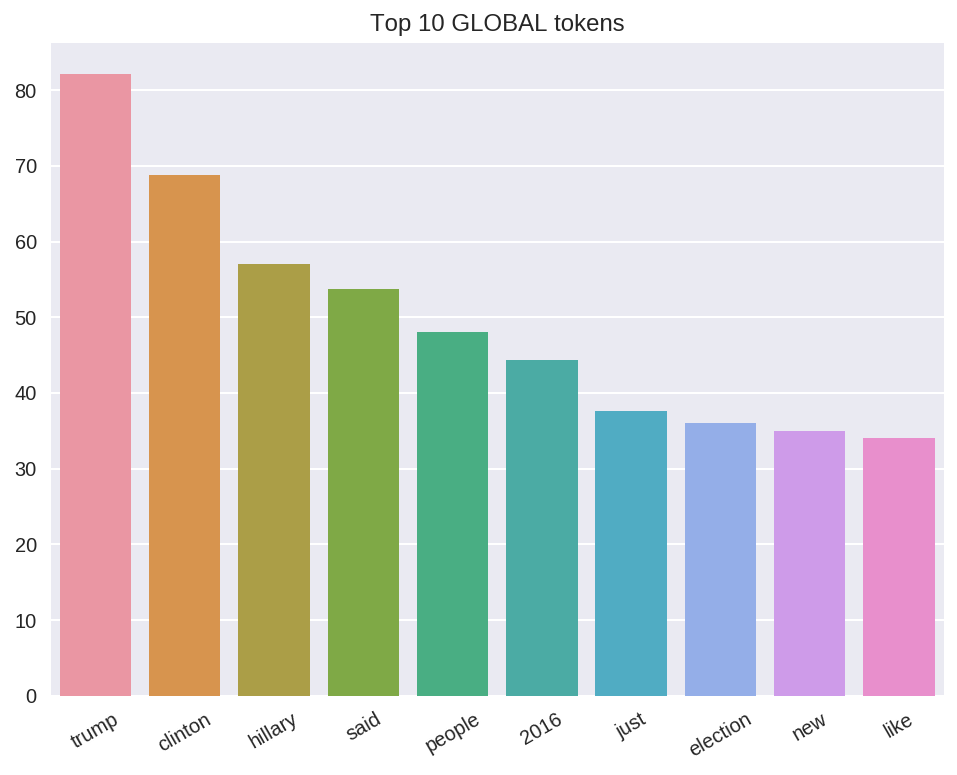

In [79]:
# Top 10 GLOBAL tokens
TF_1_ngram_bc.plot_top_tokens()

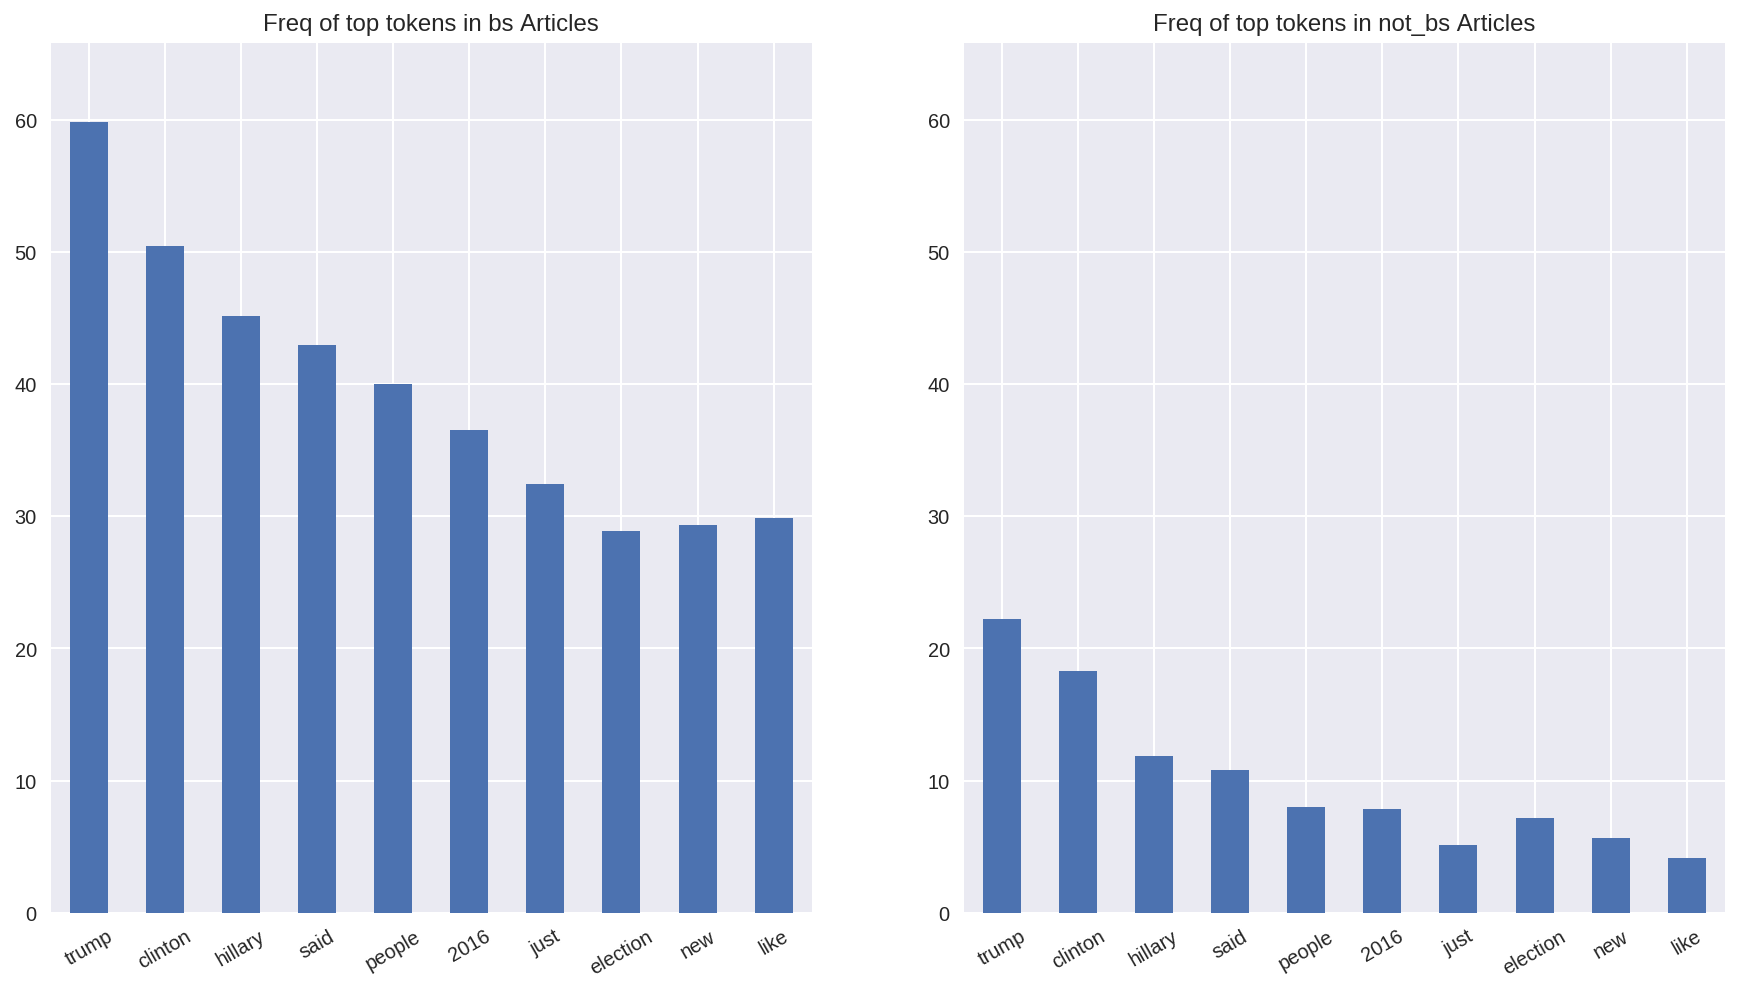

In [80]:
# Top 10 GLOBAL tokens for each label
TF_1_ngram_bc.plot_top_tokens_by_binary_label()

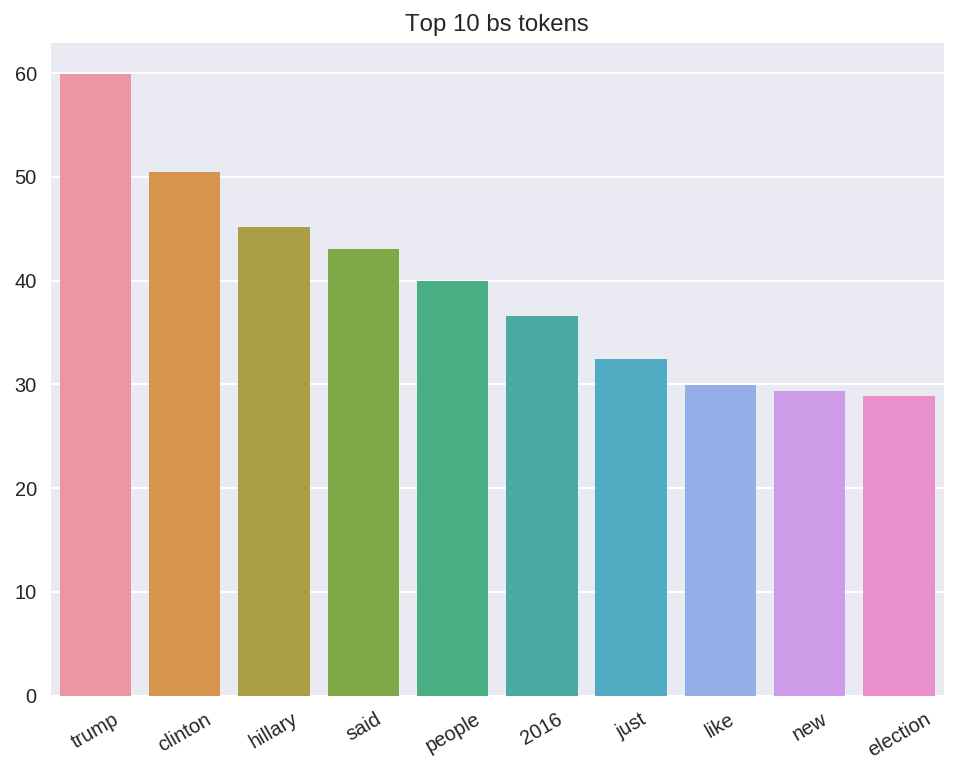

In [81]:
# Top 10 bs tokens
TF_1_ngram_bc.plot_top_tokens(label="bs")

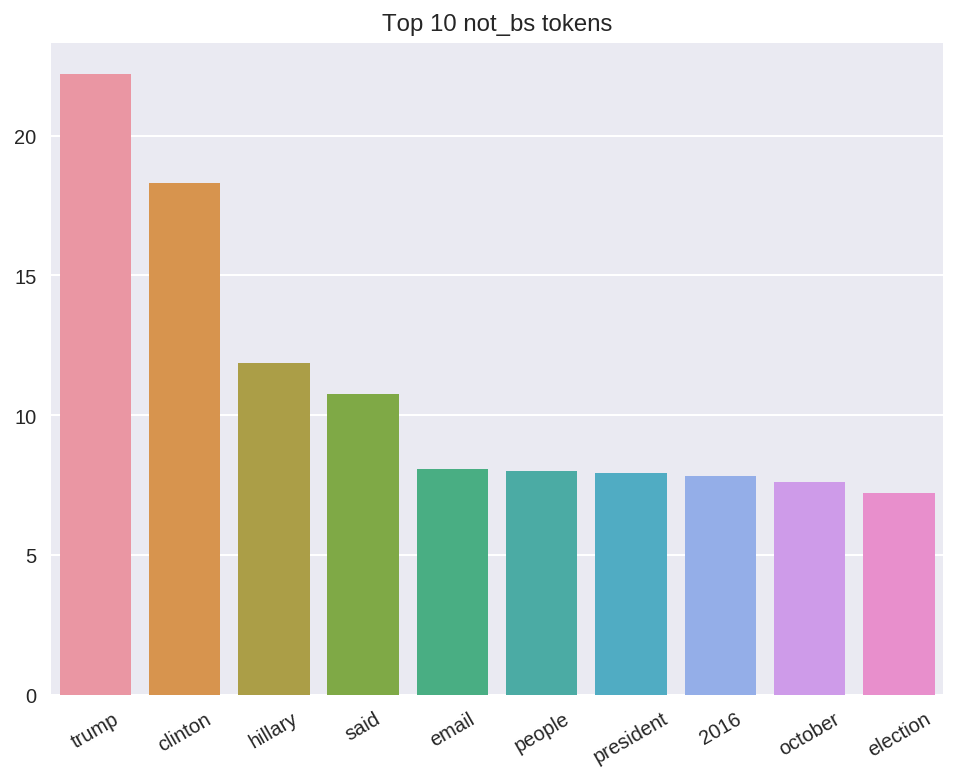

In [82]:
# Top 10 bias tokens
TF_1_ngram_bc.plot_top_tokens(label="not_bs")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram_bc.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_2_ngram_bc.plot_top_tokens_binary_label()

In [ ]:
# Top 10 bs tokens
TF_2_ngram_bc.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_2_ngram_bc.plot_top_tokens(label="not_bs")

Comey Letter to Congress

In [ ]:
# Top 10 GLOBAL tokens
TF_1_ngram_comey.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_1_ngram_comey.plot_top_tokens_by_binary_label()

In [ ]:
# Top 10 bs tokens
TF_1_ngram_comey.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_1_ngram_comey.plot_top_tokens(label="not_bs")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram_comey.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_2_ngram_comey.plot_top_tokens_by_binary_label()

In [ ]:
# Top 10 bs tokens
TF_2_ngram_comey.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_2_ngram_comey.plot_top_tokens(label="not_bs")

Election Day

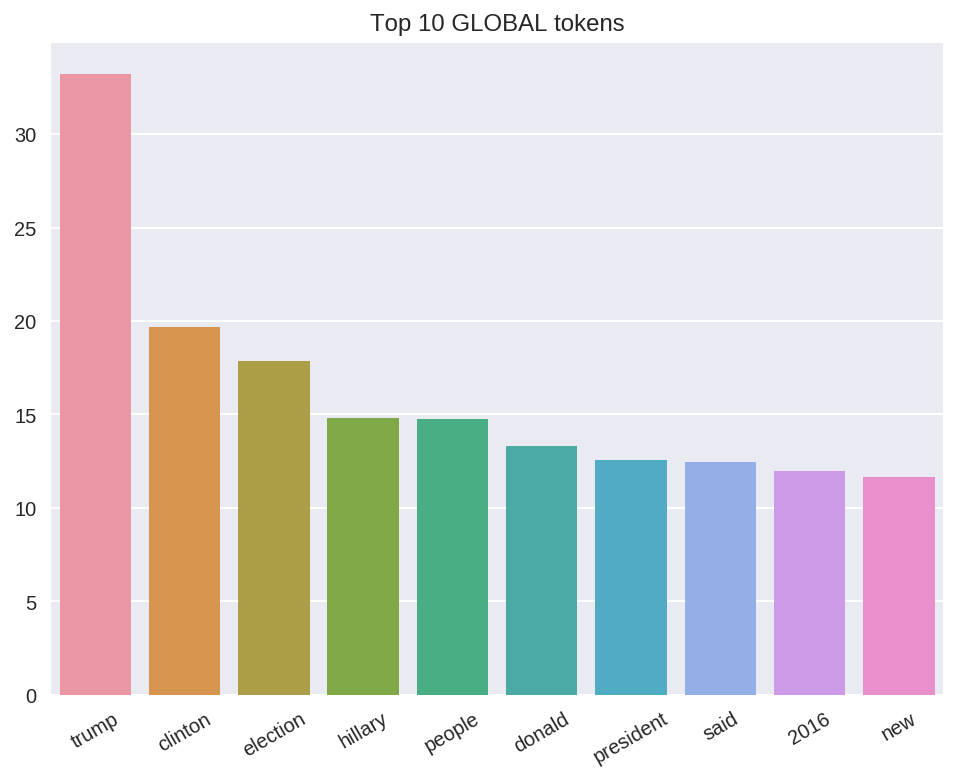

In [84]:
# Top 10 GLOBAL tokens
TF_1_ngram_election.plot_top_tokens()

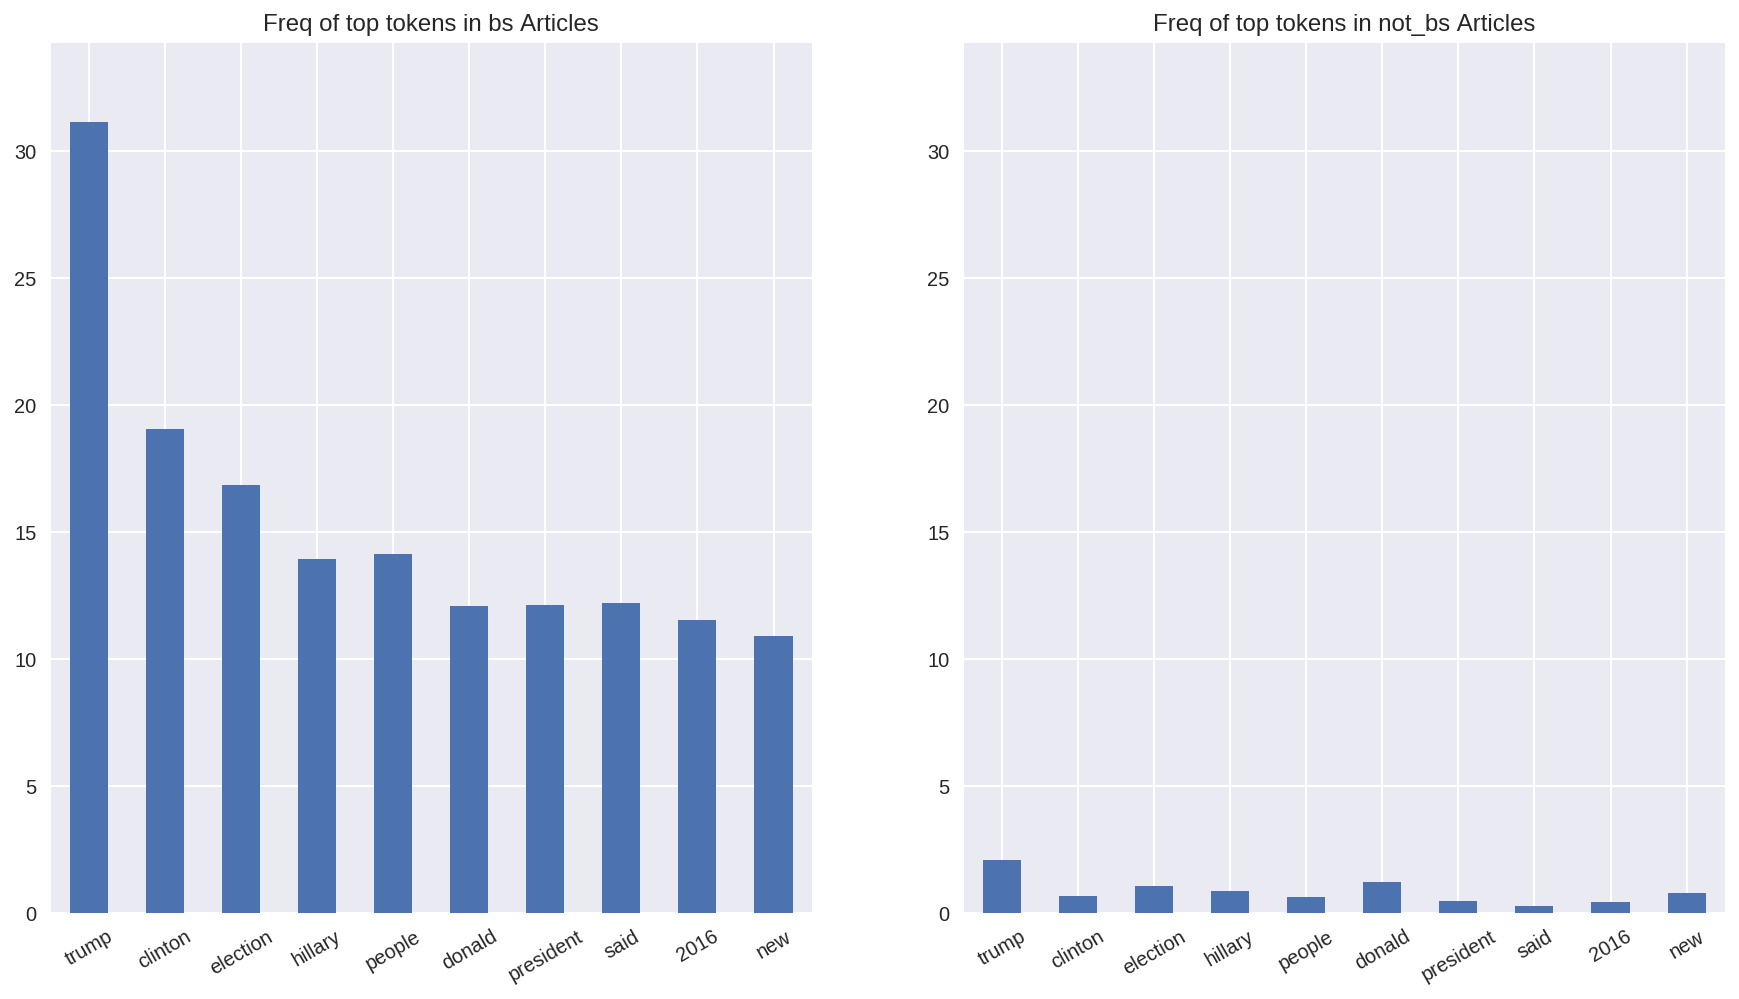

In [85]:
# Top 10 GLOBAL tokens for each label
TF_1_ngram_election.plot_top_tokens_by_binary_label()

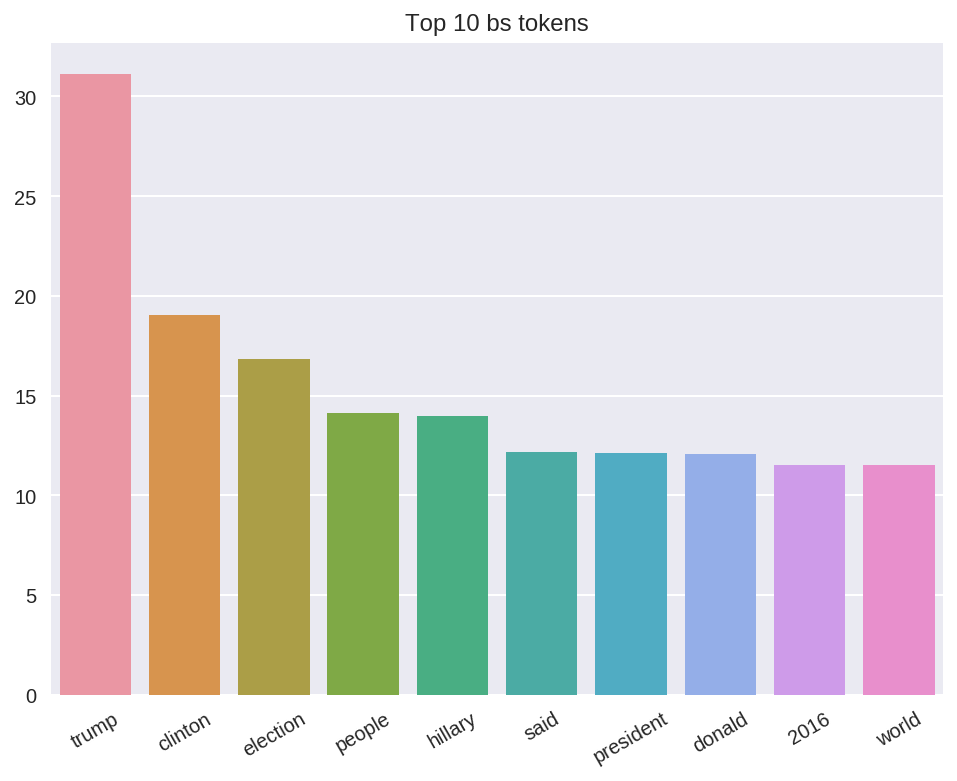

In [86]:
# Top 10 bs tokens
TF_1_ngram_election.plot_top_tokens(label="bs")

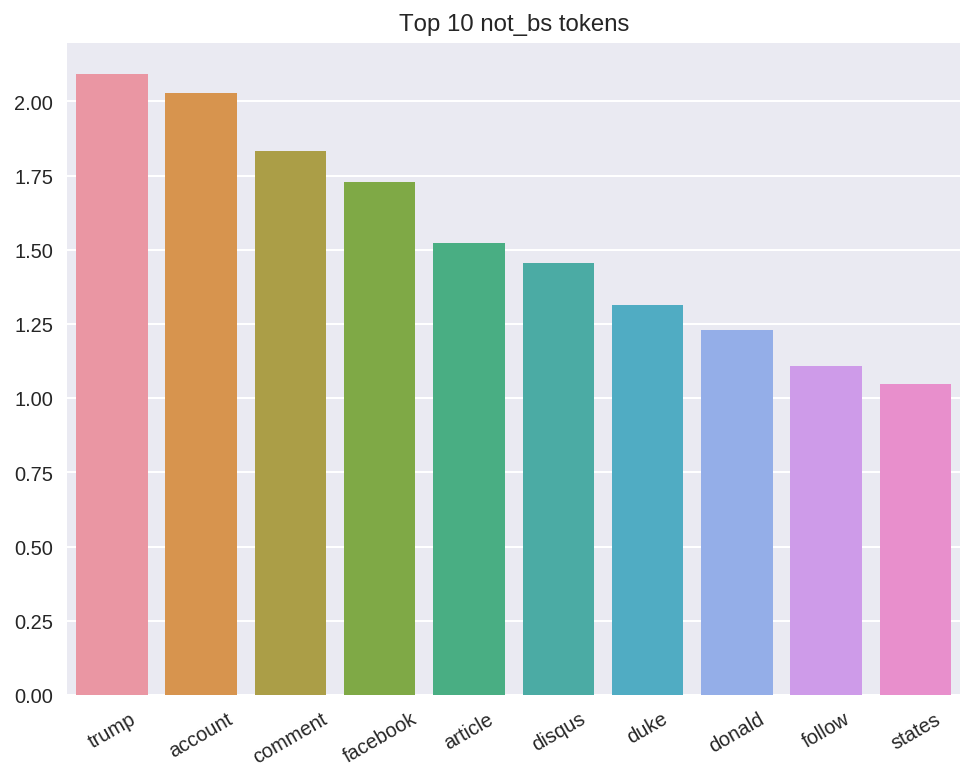

In [87]:
# Top 10 bias tokens
TF_1_ngram_election.plot_top_tokens(label="not_bs")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram_election.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_2_ngram_election.plot_top_tokens_by_label()

In [ ]:
# Top 10 bs tokens
TF_2_ngram_election.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_2_ngram_election.plot_top_tokens(label="not_bs")

After Election

In [ ]:
# Top 10 GLOBAL tokens
TF_1_ngram_ae.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_1_ngram_ae.plot_top_tokens_by_label()

In [ ]:
# Top 10 bs tokens
TF_1_ngram_bc.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_1_ngram_ae.plot_top_tokens(label="not_bs")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram_ae.plot_top_tokens()

In [ ]:
# Top 10 GLOBAL tokens for each label
TF_2_ngram_ae.plot_top_tokens_by_binary_label()

In [ ]:
# Top 10 bs tokens
TF_2_ngram_ae.plot_top_tokens(label="bs")

In [ ]:
# Top 10 bias tokens
TF_2_ngram_ae.plot_top_tokens(label="not_bs")

## Text based Modelling Approaches

Make a model based on text for McIntire dataset because the data is evenly split and we will have a baseline accuracy of 50%. We eill try naive bayes(high dimensionality), PassiveAggressive( High streams of data) 

kaggle naive bayes and random forest because of class imbalance

Here are some functions that will be helpful

In [62]:
def print_stat_report(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    specificity = tn/(tn+fp)
    
    print('specificity: {}'.format(specificity.round(2)))
    print('accuracy: {}'.format(accuracy.round(2)))
    print('precision: {}'.format(precision.round(2)))
    print('recall: {}'.format(recall.round(2)))

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, kaggle=False, n=10):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """
    
    if kaggle:
        class_labels=['bs', 'not_bs']
    else:
        class_labels = classifier.classes_
        
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


In [65]:
# Set text to X as the predictor 
X= McIntire['text']
# Set y target label 
y = McIntire["label"] 


# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [66]:
# Initialize the `tfidf_vectorizer`  with n_gram range 2,2
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.7, ngram_range=(2,2)) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [67]:
#Poor man's GridSearch
clf1 = MultinomialNB()
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    nb_pred = nb_classifier.predict(tfidf_test)
    score = accuracy_score(y_test, nb_pred)
    if score > last_score:
        clf1 = nb_classifier
        last_score=score
    print("Alpha: {:.2f} Score: {:.2f}".format(alpha, score))
    
print(clf1)

/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


Alpha: 0.00 Score: 0.54
Alpha: 0.10 Score: 0.91
Alpha: 0.20 Score: 0.90
Alpha: 0.30 Score: 0.90
Alpha: 0.40 Score: 0.89
Alpha: 0.50 Score: 0.89
Alpha: 0.60 Score: 0.89
Alpha: 0.70 Score: 0.89
Alpha: 0.80 Score: 0.88
Alpha: 0.90 Score: 0.88
MultinomialNB(alpha=0.10000000000000001, class_prior=None, fit_prior=True)


specificity: 0.78
accuracy: 0.88
precision: 0.81
recall: 0.99
Confusion matrix, without normalization


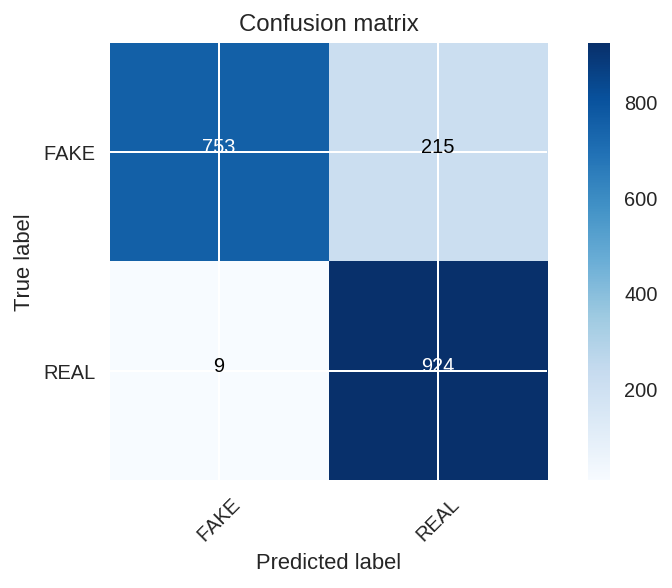

In [68]:
confusion_matrix1 = confusion_matrix(y_test, nb_pred, labels=['FAKE', 'REAL'])

print_stat_report(confusion_matrix1)

plot_confusion_matrix(confusion_matrix1, classes=['FAKE', 'REAL'])

In [69]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, clf1)

FAKE -14.2701660391 00 00
FAKE -14.2701660391 00 barrel
FAKE -14.2701660391 00 doors
FAKE -14.2701660391 00 edt
FAKE -14.2701660391 00 gallon
FAKE -14.2701660391 00 gmt
FAKE -14.2701660391 00 gov
FAKE -14.2701660391 00 lands
FAKE -14.2701660391 00 london
FAKE -14.2701660391 00 mark

REAL -9.05284827203 white house
REAL -9.19301766054 donald trump
REAL -9.27443046733 united states
REAL -9.30965968363 new york
REAL -9.32850940445 fox news
REAL -9.33666149329 hillary clinton
REAL -9.38739164858 obama administration
REAL -9.44211559949 new hampshire
REAL -9.45515458638 tax reform
REAL -9.46085495159 pushing tax


In [70]:
#Poor man's GridSearch
clf2 = PassiveAggressiveClassifier()
last_score = 0
for n_iter in [10, 20, 50, 100]:
    pa_classifier = PassiveAggressiveClassifier(n_iter=n_iter, random_state=42)
    pa_classifier.fit(tfidf_train, y_train)
    pa_pred = pa_classifier.predict(tfidf_test)
    score = accuracy_score(y_test, pa_pred)
    if score > last_score:
        clf2 = pa_classifier
        last_score=score
    print("n_iter: {} Score: {:.2f}".format(n_iter, score))

print(clf2)

n_iter: 10 Score: 0.93
n_iter: 20 Score: 0.93
n_iter: 50 Score: 0.93
n_iter: 100 Score: 0.93
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=10, n_jobs=1, random_state=42,
              shuffle=True, verbose=0, warm_start=False)


In [71]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, clf2)

FAKE -4.00871037828 november 2016
FAKE -2.99598079182 27 2016
FAKE -2.91679019733 hillary clinton
FAKE -2.75823420567 october 27
FAKE -2.28078373197 26 2016
FAKE -2.17766597698 28 2016
FAKE -2.03611964411 october 26
FAKE -2.00293330078 october 28
FAKE -1.86288281253 mainstream media
FAKE -1.70510567815 john podesta

REAL 4.04533827829 fox news
REAL 3.59052069385 white house
REAL 3.45449054861 ted cruz
REAL 3.24237455666 islamic state
REAL 3.07595229195 trump said
REAL 3.03719785064 new hampshire
REAL 2.93239807558 president obama
REAL 2.8217575223 new york
REAL 2.72698784719 obama said
REAL 2.56435047441 marco rubio


specificity: 0.9
accuracy: 0.93
precision: 0.9
recall: 0.95
Confusion matrix, without normalization


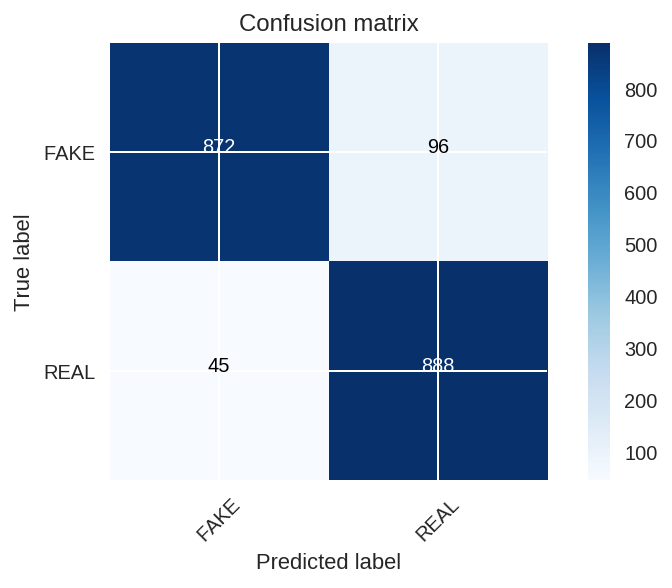

In [72]:
confusion_matrix2 = confusion_matrix(y_test, pa_pred, labels=['FAKE', 'REAL'])

print_stat_report(confusion_matrix2)

plot_confusion_matrix(confusion_matrix2, classes=['FAKE', 'REAL'])

In [73]:
# Set text to X as the predictor 
X2= kaggle['text']
# Set y target label 
y2 = kaggle["label"] 


# Make training and test sets 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=42)

In [74]:
# Initialize the `tfidf_vectorizer`  with n_gram range 2,2
tfidf_vectorizer2 = TfidfVectorizer(stop_words=stop_words, max_df=0.7, ngram_range=(2,2)) 

# Fit and transform the training data 
tfidf_train2 = tfidf_vectorizer2.fit_transform(X_train2) 

# Transform the test set 
tfidf_test2 = tfidf_vectorizer2.transform(X_test2)

In [75]:
#Poor man's GridSearch
clf3 = MultinomialNB()
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier2 = MultinomialNB(alpha=alpha)
    nb_classifier2.fit(tfidf_train2, y_train2)
    nb_pred2 = nb_classifier2.predict(tfidf_test2)
    score = accuracy_score(y_test2, nb_pred2)
    if score > last_score:
        clf1 = nb_classifier2
        last_score=score
    print("Alpha: {:.2f} Score: {:.2f}".format(alpha, score))
    
print(clf3)

/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


Alpha: 0.00 Score: 0.89
Alpha: 0.10 Score: 0.90
Alpha: 0.20 Score: 0.90
Alpha: 0.30 Score: 0.89
Alpha: 0.40 Score: 0.89
Alpha: 0.50 Score: 0.89
Alpha: 0.60 Score: 0.89
Alpha: 0.70 Score: 0.89
Alpha: 0.80 Score: 0.89
Alpha: 0.90 Score: 0.89
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


specificity: 1.0
accuracy: 0.89
precision: 1.0
recall: 0.02
Confusion matrix, without normalization


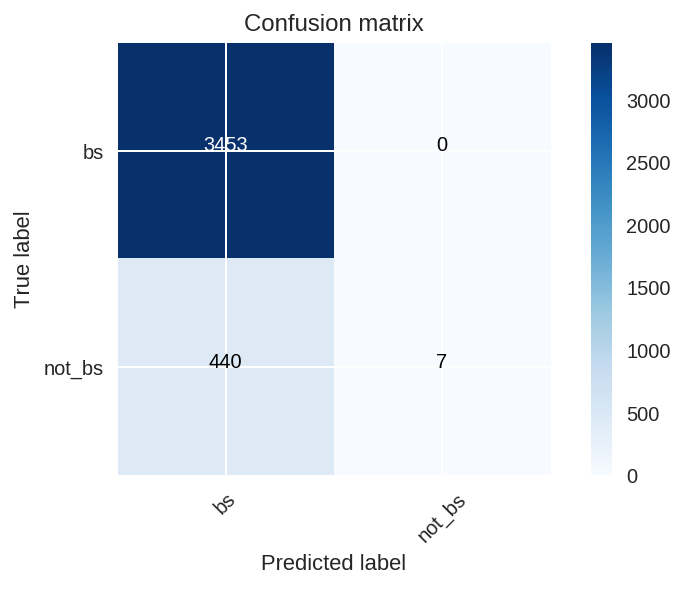

In [76]:
confusion_matrix3 = confusion_matrix(y_test2, nb_pred2, labels=['bs', 'not_bs'])

print_stat_report(confusion_matrix3)

plot_confusion_matrix(confusion_matrix3, classes=['bs', 'not_bs'])

In [77]:
clf4 = RandomForestClassifier()
clf4.fit(tfidf_train2, y_train2)
rf_pred = clf4.predict(tfidf_test2)
rf_score = accuracy_score(y_test2, rf_pred)
print("accuracy:   %0.2f" % score)


accuracy:   0.89


specificity: 0.99
accuracy: 0.91
precision: 0.81
recall: 0.24
Confusion matrix, without normalization


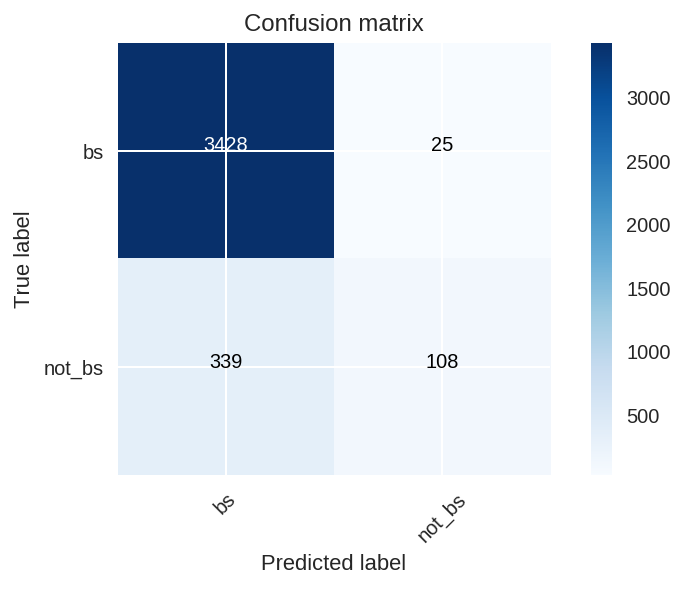

In [78]:
confusion_matrix4 = confusion_matrix(y_test2, rf_pred, labels=['bs', 'not_bs'])

print_stat_report(confusion_matrix4)

plot_confusion_matrix(confusion_matrix4, classes=['bs', 'not_bs'])